Note that in addition to `astropy` functions, this notebook also uses 

- `astropy-healpix` https://astropy-healpix.readthedocs.io/en/latest/index.html 
- `astroplan` https://astroplan.readthedocs.io/en/latest/index.html
- `reproject` https://reproject.readthedocs.io/en/stable/#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u, constants as c
from astropy.time import Time
from astropy.coordinates import get_body, Angle, SkyCoord, EarthLocation, AltAz, ICRS, Galactic, FK4, FK5, GeocentricMeanEcliptic
import astroplan as ap
from astropy_healpix import HEALPix
import reproject
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes.frame import EllipticalFrame

In [2]:
# We're going to need to sample a range of launch dates and latitude / longitude. 
# Here's something to get started
mcmurdo = EarthLocation(lat='-77.8419', lon='166.6863', height=37000.)
launch_date = Time('2026-12-25 00:00:00', scale='utc', location = mcmurdo)
launch_date = Time('2027-01-13 00:00:00', scale='utc', location = mcmurdo)

ntimes = 1000
times = launch_date + np.linspace(0, 24, ntimes)*u.hr

C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1000 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [3]:
%%time
sun_body = get_body('sun', times, location=mcmurdo)

C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 1000 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1000 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


CPU times: total: 688 ms
Wall time: 2.42 s


In [4]:
# Define the healpix coordinates
hp = HEALPix(nside=64, order='nested')
obstimemap_hp = np.zeros(hp.npix) #+ np.random.normal(size=hp.npix)

In [5]:
ra, dec = hp.healpix_to_lonlat(np.arange(hp.npix))

In [6]:
# Getting a map back from the values in a heapix array is ... a pain.
# Define a Mollweide projection header
# Probably want a function that just takes in a resolution and correctly gives a number of pixels 
mollweide_header = fits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  480
NAXIS2  =                  240
CTYPE1  = 'RA---MOL'
CRPIX1  =                240.5
CRVAL1  =                180.0
CDELT1  =               -0.675
CUNIT1  = 'deg     '
CTYPE2  = 'DEC--MOL'
CRPIX2  =                120.5
CRVAL2  =                  0.0
CDELT2  =                0.675
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')

In [12]:
observer = ap.Observer(location = mcmurdo)

In [13]:
%%time
# Not sure if this vectorization will help
skycoords = SkyCoord(ra=ra, dec=dec, obstime=times, location=mcmurdo)

CPU times: total: 0 ns
Wall time: 11 ms


In [15]:
len(times)

1000

In [14]:
skycoords_altaz = skycoords.transform_to('altaz')

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: ()->() (49152,3)->(49152,newaxis) (49152,3)->(49152,newaxis) (1000,3)->(1000,newaxis) (1000,)->(1000,newaxis) ()->()  and requested shape (3)

In [8]:
%%time
for i in np.arange(hp.npix):
    
    print(i, ' / ', hp.npix)
    
    target = SkyCoord(ra=ra[i], dec=dec[i], obstime=times, location=mcmurdo)
    # Rise and set time is cute, but we really want time between some elevation, so maybe we do this by brute force?
    target_altaz = target.transform_to('altaz')
    time_in_range = np.logical_and(target_altaz.alt.deg >= 20, target_altaz.alt.deg <=50).sum()/ntimes*24
    
    obstimemap_hp[i] = time_in_range

0  /  49152
1  /  49152
2  /  49152
3  /  49152
4  /  49152
5  /  49152
6  /  49152
7  /  49152
8  /  49152
9  /  49152
10  /  49152
11  /  49152
12  /  49152
13  /  49152
14  /  49152
15  /  49152
16  /  49152
17  /  49152
18  /  49152
19  /  49152
20  /  49152
21  /  49152
22  /  49152
23  /  49152
24  /  49152
25  /  49152
26  /  49152
27  /  49152
28  /  49152
29  /  49152
30  /  49152
31  /  49152
32  /  49152
33  /  49152
34  /  49152
35  /  49152
36  /  49152
37  /  49152
38  /  49152
39  /  49152
40  /  49152
41  /  49152
42  /  49152
43  /  49152
44  /  49152
45  /  49152
46  /  49152
47  /  49152
48  /  49152
49  /  49152
50  /  49152
51  /  49152
52  /  49152
53  /  49152
54  /  49152
55  /  49152
56  /  49152
57  /  49152
58  /  49152
59  /  49152
60  /  49152
61  /  49152
62  /  49152
63  /  49152
64  /  49152
65  /  49152
66  /  49152
67  /  49152
68  /  49152
69  /  49152
70  /  49152
71  /  49152
72  /  49152
73  /  49152
74  /  49152
75  /  49152
76  /  49152
77  /  49

595  /  49152
596  /  49152
597  /  49152
598  /  49152
599  /  49152
600  /  49152
601  /  49152
602  /  49152
603  /  49152
604  /  49152
605  /  49152
606  /  49152
607  /  49152
608  /  49152
609  /  49152
610  /  49152
611  /  49152
612  /  49152
613  /  49152
614  /  49152
615  /  49152
616  /  49152
617  /  49152
618  /  49152
619  /  49152
620  /  49152
621  /  49152
622  /  49152
623  /  49152
624  /  49152
625  /  49152
626  /  49152
627  /  49152
628  /  49152
629  /  49152
630  /  49152
631  /  49152
632  /  49152
633  /  49152
634  /  49152
635  /  49152
636  /  49152
637  /  49152
638  /  49152
639  /  49152
640  /  49152
641  /  49152
642  /  49152
643  /  49152
644  /  49152
645  /  49152
646  /  49152
647  /  49152
648  /  49152
649  /  49152
650  /  49152
651  /  49152
652  /  49152
653  /  49152
654  /  49152
655  /  49152
656  /  49152
657  /  49152
658  /  49152
659  /  49152
660  /  49152
661  /  49152
662  /  49152
663  /  49152
664  /  49152
665  /  49152
666  /

1170  /  49152
1171  /  49152
1172  /  49152
1173  /  49152
1174  /  49152
1175  /  49152
1176  /  49152
1177  /  49152
1178  /  49152
1179  /  49152
1180  /  49152
1181  /  49152
1182  /  49152
1183  /  49152
1184  /  49152
1185  /  49152
1186  /  49152
1187  /  49152
1188  /  49152
1189  /  49152
1190  /  49152
1191  /  49152
1192  /  49152
1193  /  49152
1194  /  49152
1195  /  49152
1196  /  49152
1197  /  49152
1198  /  49152
1199  /  49152
1200  /  49152
1201  /  49152
1202  /  49152
1203  /  49152
1204  /  49152
1205  /  49152
1206  /  49152
1207  /  49152
1208  /  49152
1209  /  49152
1210  /  49152
1211  /  49152
1212  /  49152
1213  /  49152
1214  /  49152
1215  /  49152
1216  /  49152
1217  /  49152
1218  /  49152
1219  /  49152
1220  /  49152
1221  /  49152
1222  /  49152
1223  /  49152
1224  /  49152
1225  /  49152
1226  /  49152
1227  /  49152
1228  /  49152
1229  /  49152
1230  /  49152
1231  /  49152
1232  /  49152
1233  /  49152
1234  /  49152
1235  /  49152
1236  /  4

1718  /  49152
1719  /  49152
1720  /  49152
1721  /  49152
1722  /  49152
1723  /  49152
1724  /  49152
1725  /  49152
1726  /  49152
1727  /  49152
1728  /  49152
1729  /  49152
1730  /  49152
1731  /  49152
1732  /  49152
1733  /  49152
1734  /  49152
1735  /  49152
1736  /  49152
1737  /  49152
1738  /  49152
1739  /  49152
1740  /  49152
1741  /  49152
1742  /  49152
1743  /  49152
1744  /  49152
1745  /  49152
1746  /  49152
1747  /  49152
1748  /  49152
1749  /  49152
1750  /  49152
1751  /  49152
1752  /  49152
1753  /  49152
1754  /  49152
1755  /  49152
1756  /  49152
1757  /  49152
1758  /  49152
1759  /  49152
1760  /  49152
1761  /  49152
1762  /  49152
1763  /  49152
1764  /  49152
1765  /  49152
1766  /  49152
1767  /  49152
1768  /  49152
1769  /  49152
1770  /  49152
1771  /  49152
1772  /  49152
1773  /  49152
1774  /  49152
1775  /  49152
1776  /  49152
1777  /  49152
1778  /  49152
1779  /  49152
1780  /  49152
1781  /  49152
1782  /  49152
1783  /  49152
1784  /  4

2266  /  49152
2267  /  49152
2268  /  49152
2269  /  49152
2270  /  49152
2271  /  49152
2272  /  49152
2273  /  49152
2274  /  49152
2275  /  49152
2276  /  49152
2277  /  49152
2278  /  49152
2279  /  49152
2280  /  49152
2281  /  49152
2282  /  49152
2283  /  49152
2284  /  49152
2285  /  49152
2286  /  49152
2287  /  49152
2288  /  49152
2289  /  49152
2290  /  49152
2291  /  49152
2292  /  49152
2293  /  49152
2294  /  49152
2295  /  49152
2296  /  49152
2297  /  49152
2298  /  49152
2299  /  49152
2300  /  49152
2301  /  49152
2302  /  49152
2303  /  49152
2304  /  49152
2305  /  49152
2306  /  49152
2307  /  49152
2308  /  49152
2309  /  49152
2310  /  49152
2311  /  49152
2312  /  49152
2313  /  49152
2314  /  49152
2315  /  49152
2316  /  49152
2317  /  49152
2318  /  49152
2319  /  49152
2320  /  49152
2321  /  49152
2322  /  49152
2323  /  49152
2324  /  49152
2325  /  49152
2326  /  49152
2327  /  49152
2328  /  49152
2329  /  49152
2330  /  49152
2331  /  49152
2332  /  4

2814  /  49152
2815  /  49152
2816  /  49152
2817  /  49152
2818  /  49152
2819  /  49152
2820  /  49152
2821  /  49152
2822  /  49152
2823  /  49152
2824  /  49152
2825  /  49152
2826  /  49152
2827  /  49152
2828  /  49152
2829  /  49152
2830  /  49152
2831  /  49152
2832  /  49152
2833  /  49152
2834  /  49152
2835  /  49152
2836  /  49152
2837  /  49152
2838  /  49152
2839  /  49152
2840  /  49152
2841  /  49152
2842  /  49152
2843  /  49152
2844  /  49152
2845  /  49152
2846  /  49152
2847  /  49152
2848  /  49152
2849  /  49152
2850  /  49152
2851  /  49152
2852  /  49152
2853  /  49152
2854  /  49152
2855  /  49152
2856  /  49152
2857  /  49152
2858  /  49152
2859  /  49152
2860  /  49152
2861  /  49152
2862  /  49152
2863  /  49152
2864  /  49152
2865  /  49152
2866  /  49152
2867  /  49152
2868  /  49152
2869  /  49152
2870  /  49152
2871  /  49152
2872  /  49152
2873  /  49152
2874  /  49152
2875  /  49152
2876  /  49152
2877  /  49152
2878  /  49152
2879  /  49152
2880  /  4

3362  /  49152
3363  /  49152
3364  /  49152
3365  /  49152
3366  /  49152
3367  /  49152
3368  /  49152
3369  /  49152
3370  /  49152
3371  /  49152
3372  /  49152
3373  /  49152
3374  /  49152
3375  /  49152
3376  /  49152
3377  /  49152
3378  /  49152
3379  /  49152
3380  /  49152
3381  /  49152
3382  /  49152
3383  /  49152
3384  /  49152
3385  /  49152
3386  /  49152
3387  /  49152
3388  /  49152
3389  /  49152
3390  /  49152
3391  /  49152
3392  /  49152
3393  /  49152
3394  /  49152
3395  /  49152
3396  /  49152
3397  /  49152
3398  /  49152
3399  /  49152
3400  /  49152
3401  /  49152
3402  /  49152
3403  /  49152
3404  /  49152
3405  /  49152
3406  /  49152
3407  /  49152
3408  /  49152
3409  /  49152
3410  /  49152
3411  /  49152
3412  /  49152
3413  /  49152
3414  /  49152
3415  /  49152
3416  /  49152
3417  /  49152
3418  /  49152
3419  /  49152
3420  /  49152
3421  /  49152
3422  /  49152
3423  /  49152
3424  /  49152
3425  /  49152
3426  /  49152
3427  /  49152
3428  /  4

3910  /  49152
3911  /  49152
3912  /  49152
3913  /  49152
3914  /  49152
3915  /  49152
3916  /  49152
3917  /  49152
3918  /  49152
3919  /  49152
3920  /  49152
3921  /  49152
3922  /  49152
3923  /  49152
3924  /  49152
3925  /  49152
3926  /  49152
3927  /  49152
3928  /  49152
3929  /  49152
3930  /  49152
3931  /  49152
3932  /  49152
3933  /  49152
3934  /  49152
3935  /  49152
3936  /  49152
3937  /  49152
3938  /  49152
3939  /  49152
3940  /  49152
3941  /  49152
3942  /  49152
3943  /  49152
3944  /  49152
3945  /  49152
3946  /  49152
3947  /  49152
3948  /  49152
3949  /  49152
3950  /  49152
3951  /  49152
3952  /  49152
3953  /  49152
3954  /  49152
3955  /  49152
3956  /  49152
3957  /  49152
3958  /  49152
3959  /  49152
3960  /  49152
3961  /  49152
3962  /  49152
3963  /  49152
3964  /  49152
3965  /  49152
3966  /  49152
3967  /  49152
3968  /  49152
3969  /  49152
3970  /  49152
3971  /  49152
3972  /  49152
3973  /  49152
3974  /  49152
3975  /  49152
3976  /  4

4458  /  49152
4459  /  49152
4460  /  49152
4461  /  49152
4462  /  49152
4463  /  49152
4464  /  49152
4465  /  49152
4466  /  49152
4467  /  49152
4468  /  49152
4469  /  49152
4470  /  49152
4471  /  49152
4472  /  49152
4473  /  49152
4474  /  49152
4475  /  49152
4476  /  49152
4477  /  49152
4478  /  49152
4479  /  49152
4480  /  49152
4481  /  49152
4482  /  49152
4483  /  49152
4484  /  49152
4485  /  49152
4486  /  49152
4487  /  49152
4488  /  49152
4489  /  49152
4490  /  49152
4491  /  49152
4492  /  49152
4493  /  49152
4494  /  49152
4495  /  49152
4496  /  49152
4497  /  49152
4498  /  49152
4499  /  49152
4500  /  49152
4501  /  49152
4502  /  49152
4503  /  49152
4504  /  49152
4505  /  49152
4506  /  49152
4507  /  49152
4508  /  49152
4509  /  49152
4510  /  49152
4511  /  49152
4512  /  49152
4513  /  49152
4514  /  49152
4515  /  49152
4516  /  49152
4517  /  49152
4518  /  49152
4519  /  49152
4520  /  49152
4521  /  49152
4522  /  49152
4523  /  49152
4524  /  4

5006  /  49152
5007  /  49152
5008  /  49152
5009  /  49152
5010  /  49152
5011  /  49152
5012  /  49152
5013  /  49152
5014  /  49152
5015  /  49152
5016  /  49152
5017  /  49152
5018  /  49152
5019  /  49152
5020  /  49152
5021  /  49152
5022  /  49152
5023  /  49152
5024  /  49152
5025  /  49152
5026  /  49152
5027  /  49152
5028  /  49152
5029  /  49152
5030  /  49152
5031  /  49152
5032  /  49152
5033  /  49152
5034  /  49152
5035  /  49152
5036  /  49152
5037  /  49152
5038  /  49152
5039  /  49152
5040  /  49152
5041  /  49152
5042  /  49152
5043  /  49152
5044  /  49152
5045  /  49152
5046  /  49152
5047  /  49152
5048  /  49152
5049  /  49152
5050  /  49152
5051  /  49152
5052  /  49152
5053  /  49152
5054  /  49152
5055  /  49152
5056  /  49152
5057  /  49152
5058  /  49152
5059  /  49152
5060  /  49152
5061  /  49152
5062  /  49152
5063  /  49152
5064  /  49152
5065  /  49152
5066  /  49152
5067  /  49152
5068  /  49152
5069  /  49152
5070  /  49152
5071  /  49152
5072  /  4

5554  /  49152
5555  /  49152
5556  /  49152
5557  /  49152
5558  /  49152
5559  /  49152
5560  /  49152
5561  /  49152
5562  /  49152
5563  /  49152
5564  /  49152
5565  /  49152
5566  /  49152
5567  /  49152
5568  /  49152
5569  /  49152
5570  /  49152
5571  /  49152
5572  /  49152
5573  /  49152
5574  /  49152
5575  /  49152
5576  /  49152
5577  /  49152
5578  /  49152
5579  /  49152
5580  /  49152
5581  /  49152
5582  /  49152
5583  /  49152
5584  /  49152
5585  /  49152
5586  /  49152
5587  /  49152
5588  /  49152
5589  /  49152
5590  /  49152
5591  /  49152
5592  /  49152
5593  /  49152
5594  /  49152
5595  /  49152
5596  /  49152
5597  /  49152
5598  /  49152
5599  /  49152
5600  /  49152
5601  /  49152
5602  /  49152
5603  /  49152
5604  /  49152
5605  /  49152
5606  /  49152
5607  /  49152
5608  /  49152
5609  /  49152
5610  /  49152
5611  /  49152
5612  /  49152
5613  /  49152
5614  /  49152
5615  /  49152
5616  /  49152
5617  /  49152
5618  /  49152
5619  /  49152
5620  /  4

6102  /  49152
6103  /  49152
6104  /  49152
6105  /  49152
6106  /  49152
6107  /  49152
6108  /  49152
6109  /  49152
6110  /  49152
6111  /  49152
6112  /  49152
6113  /  49152
6114  /  49152
6115  /  49152
6116  /  49152
6117  /  49152
6118  /  49152
6119  /  49152
6120  /  49152
6121  /  49152
6122  /  49152
6123  /  49152
6124  /  49152
6125  /  49152
6126  /  49152
6127  /  49152
6128  /  49152
6129  /  49152
6130  /  49152
6131  /  49152
6132  /  49152
6133  /  49152
6134  /  49152
6135  /  49152
6136  /  49152
6137  /  49152
6138  /  49152
6139  /  49152
6140  /  49152
6141  /  49152
6142  /  49152
6143  /  49152
6144  /  49152
6145  /  49152
6146  /  49152
6147  /  49152
6148  /  49152
6149  /  49152
6150  /  49152
6151  /  49152
6152  /  49152
6153  /  49152
6154  /  49152
6155  /  49152
6156  /  49152
6157  /  49152
6158  /  49152
6159  /  49152
6160  /  49152
6161  /  49152
6162  /  49152
6163  /  49152
6164  /  49152
6165  /  49152
6166  /  49152
6167  /  49152
6168  /  4

6650  /  49152
6651  /  49152
6652  /  49152
6653  /  49152
6654  /  49152
6655  /  49152
6656  /  49152
6657  /  49152
6658  /  49152
6659  /  49152
6660  /  49152
6661  /  49152
6662  /  49152
6663  /  49152
6664  /  49152
6665  /  49152
6666  /  49152
6667  /  49152
6668  /  49152
6669  /  49152
6670  /  49152
6671  /  49152
6672  /  49152
6673  /  49152
6674  /  49152
6675  /  49152
6676  /  49152
6677  /  49152
6678  /  49152
6679  /  49152
6680  /  49152
6681  /  49152
6682  /  49152
6683  /  49152
6684  /  49152
6685  /  49152
6686  /  49152
6687  /  49152
6688  /  49152
6689  /  49152
6690  /  49152
6691  /  49152
6692  /  49152
6693  /  49152
6694  /  49152
6695  /  49152
6696  /  49152
6697  /  49152
6698  /  49152
6699  /  49152
6700  /  49152
6701  /  49152
6702  /  49152
6703  /  49152
6704  /  49152
6705  /  49152
6706  /  49152
6707  /  49152
6708  /  49152
6709  /  49152
6710  /  49152
6711  /  49152
6712  /  49152
6713  /  49152
6714  /  49152
6715  /  49152
6716  /  4

7198  /  49152
7199  /  49152
7200  /  49152
7201  /  49152
7202  /  49152
7203  /  49152
7204  /  49152
7205  /  49152
7206  /  49152
7207  /  49152
7208  /  49152
7209  /  49152
7210  /  49152
7211  /  49152
7212  /  49152
7213  /  49152
7214  /  49152
7215  /  49152
7216  /  49152
7217  /  49152
7218  /  49152
7219  /  49152
7220  /  49152
7221  /  49152
7222  /  49152
7223  /  49152
7224  /  49152
7225  /  49152
7226  /  49152
7227  /  49152
7228  /  49152
7229  /  49152
7230  /  49152
7231  /  49152
7232  /  49152
7233  /  49152
7234  /  49152
7235  /  49152
7236  /  49152
7237  /  49152
7238  /  49152
7239  /  49152
7240  /  49152
7241  /  49152
7242  /  49152
7243  /  49152
7244  /  49152
7245  /  49152
7246  /  49152
7247  /  49152
7248  /  49152
7249  /  49152
7250  /  49152
7251  /  49152
7252  /  49152
7253  /  49152
7254  /  49152
7255  /  49152
7256  /  49152
7257  /  49152
7258  /  49152
7259  /  49152
7260  /  49152
7261  /  49152
7262  /  49152
7263  /  49152
7264  /  4

7746  /  49152
7747  /  49152
7748  /  49152
7749  /  49152
7750  /  49152
7751  /  49152
7752  /  49152
7753  /  49152
7754  /  49152
7755  /  49152
7756  /  49152
7757  /  49152
7758  /  49152
7759  /  49152
7760  /  49152
7761  /  49152
7762  /  49152
7763  /  49152
7764  /  49152
7765  /  49152
7766  /  49152
7767  /  49152
7768  /  49152
7769  /  49152
7770  /  49152
7771  /  49152
7772  /  49152
7773  /  49152
7774  /  49152
7775  /  49152
7776  /  49152
7777  /  49152
7778  /  49152
7779  /  49152
7780  /  49152
7781  /  49152
7782  /  49152
7783  /  49152
7784  /  49152
7785  /  49152
7786  /  49152
7787  /  49152
7788  /  49152
7789  /  49152
7790  /  49152
7791  /  49152
7792  /  49152
7793  /  49152
7794  /  49152
7795  /  49152
7796  /  49152
7797  /  49152
7798  /  49152
7799  /  49152
7800  /  49152
7801  /  49152
7802  /  49152
7803  /  49152
7804  /  49152
7805  /  49152
7806  /  49152
7807  /  49152
7808  /  49152
7809  /  49152
7810  /  49152
7811  /  49152
7812  /  4

8294  /  49152
8295  /  49152
8296  /  49152
8297  /  49152
8298  /  49152
8299  /  49152
8300  /  49152
8301  /  49152
8302  /  49152
8303  /  49152
8304  /  49152
8305  /  49152
8306  /  49152
8307  /  49152
8308  /  49152
8309  /  49152
8310  /  49152
8311  /  49152
8312  /  49152
8313  /  49152
8314  /  49152
8315  /  49152
8316  /  49152
8317  /  49152
8318  /  49152
8319  /  49152
8320  /  49152
8321  /  49152
8322  /  49152
8323  /  49152
8324  /  49152
8325  /  49152
8326  /  49152
8327  /  49152
8328  /  49152
8329  /  49152
8330  /  49152
8331  /  49152
8332  /  49152
8333  /  49152
8334  /  49152
8335  /  49152
8336  /  49152
8337  /  49152
8338  /  49152
8339  /  49152
8340  /  49152
8341  /  49152
8342  /  49152
8343  /  49152
8344  /  49152
8345  /  49152
8346  /  49152
8347  /  49152
8348  /  49152
8349  /  49152
8350  /  49152
8351  /  49152
8352  /  49152
8353  /  49152
8354  /  49152
8355  /  49152
8356  /  49152
8357  /  49152
8358  /  49152
8359  /  49152
8360  /  4

8842  /  49152
8843  /  49152
8844  /  49152
8845  /  49152
8846  /  49152
8847  /  49152
8848  /  49152
8849  /  49152
8850  /  49152
8851  /  49152
8852  /  49152
8853  /  49152
8854  /  49152
8855  /  49152
8856  /  49152
8857  /  49152
8858  /  49152
8859  /  49152
8860  /  49152
8861  /  49152
8862  /  49152
8863  /  49152
8864  /  49152
8865  /  49152
8866  /  49152
8867  /  49152
8868  /  49152
8869  /  49152
8870  /  49152
8871  /  49152
8872  /  49152
8873  /  49152
8874  /  49152
8875  /  49152
8876  /  49152
8877  /  49152
8878  /  49152
8879  /  49152
8880  /  49152
8881  /  49152
8882  /  49152
8883  /  49152
8884  /  49152
8885  /  49152
8886  /  49152
8887  /  49152
8888  /  49152
8889  /  49152
8890  /  49152
8891  /  49152
8892  /  49152
8893  /  49152
8894  /  49152
8895  /  49152
8896  /  49152
8897  /  49152
8898  /  49152
8899  /  49152
8900  /  49152
8901  /  49152
8902  /  49152
8903  /  49152
8904  /  49152
8905  /  49152
8906  /  49152
8907  /  49152
8908  /  4

9389  /  49152
9390  /  49152
9391  /  49152
9392  /  49152
9393  /  49152
9394  /  49152
9395  /  49152
9396  /  49152
9397  /  49152
9398  /  49152
9399  /  49152
9400  /  49152
9401  /  49152
9402  /  49152
9403  /  49152
9404  /  49152
9405  /  49152
9406  /  49152
9407  /  49152
9408  /  49152
9409  /  49152
9410  /  49152
9411  /  49152
9412  /  49152
9413  /  49152
9414  /  49152
9415  /  49152
9416  /  49152
9417  /  49152
9418  /  49152
9419  /  49152
9420  /  49152
9421  /  49152
9422  /  49152
9423  /  49152
9424  /  49152
9425  /  49152
9426  /  49152
9427  /  49152
9428  /  49152
9429  /  49152
9430  /  49152
9431  /  49152
9432  /  49152
9433  /  49152
9434  /  49152
9435  /  49152
9436  /  49152
9437  /  49152
9438  /  49152
9439  /  49152
9440  /  49152
9441  /  49152
9442  /  49152
9443  /  49152
9444  /  49152
9445  /  49152
9446  /  49152
9447  /  49152
9448  /  49152
9449  /  49152
9450  /  49152
9451  /  49152
9452  /  49152
9453  /  49152
9454  /  49152
9455  /  4

9937  /  49152
9938  /  49152
9939  /  49152
9940  /  49152
9941  /  49152
9942  /  49152
9943  /  49152
9944  /  49152
9945  /  49152
9946  /  49152
9947  /  49152
9948  /  49152
9949  /  49152
9950  /  49152
9951  /  49152
9952  /  49152
9953  /  49152
9954  /  49152
9955  /  49152
9956  /  49152
9957  /  49152
9958  /  49152
9959  /  49152
9960  /  49152
9961  /  49152
9962  /  49152
9963  /  49152
9964  /  49152
9965  /  49152
9966  /  49152
9967  /  49152
9968  /  49152
9969  /  49152
9970  /  49152
9971  /  49152
9972  /  49152
9973  /  49152
9974  /  49152
9975  /  49152
9976  /  49152
9977  /  49152
9978  /  49152
9979  /  49152
9980  /  49152
9981  /  49152
9982  /  49152
9983  /  49152
9984  /  49152
9985  /  49152
9986  /  49152
9987  /  49152
9988  /  49152
9989  /  49152
9990  /  49152
9991  /  49152
9992  /  49152
9993  /  49152
9994  /  49152
9995  /  49152
9996  /  49152
9997  /  49152
9998  /  49152
9999  /  49152
10000  /  49152
10001  /  49152
10002  /  49152
10003  

10453  /  49152
10454  /  49152
10455  /  49152
10456  /  49152
10457  /  49152
10458  /  49152
10459  /  49152
10460  /  49152
10461  /  49152
10462  /  49152
10463  /  49152
10464  /  49152
10465  /  49152
10466  /  49152
10467  /  49152
10468  /  49152
10469  /  49152
10470  /  49152
10471  /  49152
10472  /  49152
10473  /  49152
10474  /  49152
10475  /  49152
10476  /  49152
10477  /  49152
10478  /  49152
10479  /  49152
10480  /  49152
10481  /  49152
10482  /  49152
10483  /  49152
10484  /  49152
10485  /  49152
10486  /  49152
10487  /  49152
10488  /  49152
10489  /  49152
10490  /  49152
10491  /  49152
10492  /  49152
10493  /  49152
10494  /  49152
10495  /  49152
10496  /  49152
10497  /  49152
10498  /  49152
10499  /  49152
10500  /  49152
10501  /  49152
10502  /  49152
10503  /  49152
10504  /  49152
10505  /  49152
10506  /  49152
10507  /  49152
10508  /  49152
10509  /  49152
10510  /  49152
10511  /  49152
10512  /  49152
10513  /  49152
10514  /  49152
10515  /

10967  /  49152
10968  /  49152
10969  /  49152
10970  /  49152
10971  /  49152
10972  /  49152
10973  /  49152
10974  /  49152
10975  /  49152
10976  /  49152
10977  /  49152
10978  /  49152
10979  /  49152
10980  /  49152
10981  /  49152
10982  /  49152
10983  /  49152
10984  /  49152
10985  /  49152
10986  /  49152
10987  /  49152
10988  /  49152
10989  /  49152
10990  /  49152
10991  /  49152
10992  /  49152
10993  /  49152
10994  /  49152
10995  /  49152
10996  /  49152
10997  /  49152
10998  /  49152
10999  /  49152
11000  /  49152
11001  /  49152
11002  /  49152
11003  /  49152
11004  /  49152
11005  /  49152
11006  /  49152
11007  /  49152
11008  /  49152
11009  /  49152
11010  /  49152
11011  /  49152
11012  /  49152
11013  /  49152
11014  /  49152
11015  /  49152
11016  /  49152
11017  /  49152
11018  /  49152
11019  /  49152
11020  /  49152
11021  /  49152
11022  /  49152
11023  /  49152
11024  /  49152
11025  /  49152
11026  /  49152
11027  /  49152
11028  /  49152
11029  /

11481  /  49152
11482  /  49152
11483  /  49152
11484  /  49152
11485  /  49152
11486  /  49152
11487  /  49152
11488  /  49152
11489  /  49152
11490  /  49152
11491  /  49152
11492  /  49152
11493  /  49152
11494  /  49152
11495  /  49152
11496  /  49152
11497  /  49152
11498  /  49152
11499  /  49152
11500  /  49152
11501  /  49152
11502  /  49152
11503  /  49152
11504  /  49152
11505  /  49152
11506  /  49152
11507  /  49152
11508  /  49152
11509  /  49152
11510  /  49152
11511  /  49152
11512  /  49152
11513  /  49152
11514  /  49152
11515  /  49152
11516  /  49152
11517  /  49152
11518  /  49152
11519  /  49152
11520  /  49152
11521  /  49152
11522  /  49152
11523  /  49152
11524  /  49152
11525  /  49152
11526  /  49152
11527  /  49152
11528  /  49152
11529  /  49152
11530  /  49152
11531  /  49152
11532  /  49152
11533  /  49152
11534  /  49152
11535  /  49152
11536  /  49152
11537  /  49152
11538  /  49152
11539  /  49152
11540  /  49152
11541  /  49152
11542  /  49152
11543  /

11995  /  49152
11996  /  49152
11997  /  49152
11998  /  49152
11999  /  49152
12000  /  49152
12001  /  49152
12002  /  49152
12003  /  49152
12004  /  49152
12005  /  49152
12006  /  49152
12007  /  49152
12008  /  49152
12009  /  49152
12010  /  49152
12011  /  49152
12012  /  49152
12013  /  49152
12014  /  49152
12015  /  49152
12016  /  49152
12017  /  49152
12018  /  49152
12019  /  49152
12020  /  49152
12021  /  49152
12022  /  49152
12023  /  49152
12024  /  49152
12025  /  49152
12026  /  49152
12027  /  49152
12028  /  49152
12029  /  49152
12030  /  49152
12031  /  49152
12032  /  49152
12033  /  49152
12034  /  49152
12035  /  49152
12036  /  49152
12037  /  49152
12038  /  49152
12039  /  49152
12040  /  49152
12041  /  49152
12042  /  49152
12043  /  49152
12044  /  49152
12045  /  49152
12046  /  49152
12047  /  49152
12048  /  49152
12049  /  49152
12050  /  49152
12051  /  49152
12052  /  49152
12053  /  49152
12054  /  49152
12055  /  49152
12056  /  49152
12057  /

12509  /  49152
12510  /  49152
12511  /  49152
12512  /  49152
12513  /  49152
12514  /  49152
12515  /  49152
12516  /  49152
12517  /  49152
12518  /  49152
12519  /  49152
12520  /  49152
12521  /  49152
12522  /  49152
12523  /  49152
12524  /  49152
12525  /  49152
12526  /  49152
12527  /  49152
12528  /  49152
12529  /  49152
12530  /  49152
12531  /  49152
12532  /  49152
12533  /  49152
12534  /  49152
12535  /  49152
12536  /  49152
12537  /  49152
12538  /  49152
12539  /  49152
12540  /  49152
12541  /  49152
12542  /  49152
12543  /  49152
12544  /  49152
12545  /  49152
12546  /  49152
12547  /  49152
12548  /  49152
12549  /  49152
12550  /  49152
12551  /  49152
12552  /  49152
12553  /  49152
12554  /  49152
12555  /  49152
12556  /  49152
12557  /  49152
12558  /  49152
12559  /  49152
12560  /  49152
12561  /  49152
12562  /  49152
12563  /  49152
12564  /  49152
12565  /  49152
12566  /  49152
12567  /  49152
12568  /  49152
12569  /  49152
12570  /  49152
12571  /

13022  /  49152
13023  /  49152
13024  /  49152
13025  /  49152
13026  /  49152
13027  /  49152
13028  /  49152
13029  /  49152
13030  /  49152
13031  /  49152
13032  /  49152
13033  /  49152
13034  /  49152
13035  /  49152
13036  /  49152
13037  /  49152
13038  /  49152
13039  /  49152
13040  /  49152
13041  /  49152
13042  /  49152
13043  /  49152
13044  /  49152
13045  /  49152
13046  /  49152
13047  /  49152
13048  /  49152
13049  /  49152
13050  /  49152
13051  /  49152
13052  /  49152
13053  /  49152
13054  /  49152
13055  /  49152
13056  /  49152
13057  /  49152
13058  /  49152
13059  /  49152
13060  /  49152
13061  /  49152
13062  /  49152
13063  /  49152
13064  /  49152
13065  /  49152
13066  /  49152
13067  /  49152
13068  /  49152
13069  /  49152
13070  /  49152
13071  /  49152
13072  /  49152
13073  /  49152
13074  /  49152
13075  /  49152
13076  /  49152
13077  /  49152
13078  /  49152
13079  /  49152
13080  /  49152
13081  /  49152
13082  /  49152
13083  /  49152
13084  /

13536  /  49152
13537  /  49152
13538  /  49152
13539  /  49152
13540  /  49152
13541  /  49152
13542  /  49152
13543  /  49152
13544  /  49152
13545  /  49152
13546  /  49152
13547  /  49152
13548  /  49152
13549  /  49152
13550  /  49152
13551  /  49152
13552  /  49152
13553  /  49152
13554  /  49152
13555  /  49152
13556  /  49152
13557  /  49152
13558  /  49152
13559  /  49152
13560  /  49152
13561  /  49152
13562  /  49152
13563  /  49152
13564  /  49152
13565  /  49152
13566  /  49152
13567  /  49152
13568  /  49152
13569  /  49152
13570  /  49152
13571  /  49152
13572  /  49152
13573  /  49152
13574  /  49152
13575  /  49152
13576  /  49152
13577  /  49152
13578  /  49152
13579  /  49152
13580  /  49152
13581  /  49152
13582  /  49152
13583  /  49152
13584  /  49152
13585  /  49152
13586  /  49152
13587  /  49152
13588  /  49152
13589  /  49152
13590  /  49152
13591  /  49152
13592  /  49152
13593  /  49152
13594  /  49152
13595  /  49152
13596  /  49152
13597  /  49152
13598  /

14050  /  49152
14051  /  49152
14052  /  49152
14053  /  49152
14054  /  49152
14055  /  49152
14056  /  49152
14057  /  49152
14058  /  49152
14059  /  49152
14060  /  49152
14061  /  49152
14062  /  49152
14063  /  49152
14064  /  49152
14065  /  49152
14066  /  49152
14067  /  49152
14068  /  49152
14069  /  49152
14070  /  49152
14071  /  49152
14072  /  49152
14073  /  49152
14074  /  49152
14075  /  49152
14076  /  49152
14077  /  49152
14078  /  49152
14079  /  49152
14080  /  49152
14081  /  49152
14082  /  49152
14083  /  49152
14084  /  49152
14085  /  49152
14086  /  49152
14087  /  49152
14088  /  49152
14089  /  49152
14090  /  49152
14091  /  49152
14092  /  49152
14093  /  49152
14094  /  49152
14095  /  49152
14096  /  49152
14097  /  49152
14098  /  49152
14099  /  49152
14100  /  49152
14101  /  49152
14102  /  49152
14103  /  49152
14104  /  49152
14105  /  49152
14106  /  49152
14107  /  49152
14108  /  49152
14109  /  49152
14110  /  49152
14111  /  49152
14112  /

14563  /  49152
14564  /  49152
14565  /  49152
14566  /  49152
14567  /  49152
14568  /  49152
14569  /  49152
14570  /  49152
14571  /  49152
14572  /  49152
14573  /  49152
14574  /  49152
14575  /  49152
14576  /  49152
14577  /  49152
14578  /  49152
14579  /  49152
14580  /  49152
14581  /  49152
14582  /  49152
14583  /  49152
14584  /  49152
14585  /  49152
14586  /  49152
14587  /  49152
14588  /  49152
14589  /  49152
14590  /  49152
14591  /  49152
14592  /  49152
14593  /  49152
14594  /  49152
14595  /  49152
14596  /  49152
14597  /  49152
14598  /  49152
14599  /  49152
14600  /  49152
14601  /  49152
14602  /  49152
14603  /  49152
14604  /  49152
14605  /  49152
14606  /  49152
14607  /  49152
14608  /  49152
14609  /  49152
14610  /  49152
14611  /  49152
14612  /  49152
14613  /  49152
14614  /  49152
14615  /  49152
14616  /  49152
14617  /  49152
14618  /  49152
14619  /  49152
14620  /  49152
14621  /  49152
14622  /  49152
14623  /  49152
14624  /  49152
14625  /

15077  /  49152
15078  /  49152
15079  /  49152
15080  /  49152
15081  /  49152
15082  /  49152
15083  /  49152
15084  /  49152
15085  /  49152
15086  /  49152
15087  /  49152
15088  /  49152
15089  /  49152
15090  /  49152
15091  /  49152
15092  /  49152
15093  /  49152
15094  /  49152
15095  /  49152
15096  /  49152
15097  /  49152
15098  /  49152
15099  /  49152
15100  /  49152
15101  /  49152
15102  /  49152
15103  /  49152
15104  /  49152
15105  /  49152
15106  /  49152
15107  /  49152
15108  /  49152
15109  /  49152
15110  /  49152
15111  /  49152
15112  /  49152
15113  /  49152
15114  /  49152
15115  /  49152
15116  /  49152
15117  /  49152
15118  /  49152
15119  /  49152
15120  /  49152
15121  /  49152
15122  /  49152
15123  /  49152
15124  /  49152
15125  /  49152
15126  /  49152
15127  /  49152
15128  /  49152
15129  /  49152
15130  /  49152
15131  /  49152
15132  /  49152
15133  /  49152
15134  /  49152
15135  /  49152
15136  /  49152
15137  /  49152
15138  /  49152
15139  /

15591  /  49152
15592  /  49152
15593  /  49152
15594  /  49152
15595  /  49152
15596  /  49152
15597  /  49152
15598  /  49152
15599  /  49152
15600  /  49152
15601  /  49152
15602  /  49152
15603  /  49152
15604  /  49152
15605  /  49152
15606  /  49152
15607  /  49152
15608  /  49152
15609  /  49152
15610  /  49152
15611  /  49152
15612  /  49152
15613  /  49152
15614  /  49152
15615  /  49152
15616  /  49152
15617  /  49152
15618  /  49152
15619  /  49152
15620  /  49152
15621  /  49152
15622  /  49152
15623  /  49152
15624  /  49152
15625  /  49152
15626  /  49152
15627  /  49152
15628  /  49152
15629  /  49152
15630  /  49152
15631  /  49152
15632  /  49152
15633  /  49152
15634  /  49152
15635  /  49152
15636  /  49152
15637  /  49152
15638  /  49152
15639  /  49152
15640  /  49152
15641  /  49152
15642  /  49152
15643  /  49152
15644  /  49152
15645  /  49152
15646  /  49152
15647  /  49152
15648  /  49152
15649  /  49152
15650  /  49152
15651  /  49152
15652  /  49152
15653  /

16105  /  49152
16106  /  49152
16107  /  49152
16108  /  49152
16109  /  49152
16110  /  49152
16111  /  49152
16112  /  49152
16113  /  49152
16114  /  49152
16115  /  49152
16116  /  49152
16117  /  49152
16118  /  49152
16119  /  49152
16120  /  49152
16121  /  49152
16122  /  49152
16123  /  49152
16124  /  49152
16125  /  49152
16126  /  49152
16127  /  49152
16128  /  49152
16129  /  49152
16130  /  49152
16131  /  49152
16132  /  49152
16133  /  49152
16134  /  49152
16135  /  49152
16136  /  49152
16137  /  49152
16138  /  49152
16139  /  49152
16140  /  49152
16141  /  49152
16142  /  49152
16143  /  49152
16144  /  49152
16145  /  49152
16146  /  49152
16147  /  49152
16148  /  49152
16149  /  49152
16150  /  49152
16151  /  49152
16152  /  49152
16153  /  49152
16154  /  49152
16155  /  49152
16156  /  49152
16157  /  49152
16158  /  49152
16159  /  49152
16160  /  49152
16161  /  49152
16162  /  49152
16163  /  49152
16164  /  49152
16165  /  49152
16166  /  49152
16167  /

16619  /  49152
16620  /  49152
16621  /  49152
16622  /  49152
16623  /  49152
16624  /  49152
16625  /  49152
16626  /  49152
16627  /  49152
16628  /  49152
16629  /  49152
16630  /  49152
16631  /  49152
16632  /  49152
16633  /  49152
16634  /  49152
16635  /  49152
16636  /  49152
16637  /  49152
16638  /  49152
16639  /  49152
16640  /  49152
16641  /  49152
16642  /  49152
16643  /  49152
16644  /  49152
16645  /  49152
16646  /  49152
16647  /  49152
16648  /  49152
16649  /  49152
16650  /  49152
16651  /  49152
16652  /  49152
16653  /  49152
16654  /  49152
16655  /  49152
16656  /  49152
16657  /  49152
16658  /  49152
16659  /  49152
16660  /  49152
16661  /  49152
16662  /  49152
16663  /  49152
16664  /  49152
16665  /  49152
16666  /  49152
16667  /  49152
16668  /  49152
16669  /  49152
16670  /  49152
16671  /  49152
16672  /  49152
16673  /  49152
16674  /  49152
16675  /  49152
16676  /  49152
16677  /  49152
16678  /  49152
16679  /  49152
16680  /  49152
16681  /

17133  /  49152
17134  /  49152
17135  /  49152
17136  /  49152
17137  /  49152
17138  /  49152
17139  /  49152
17140  /  49152
17141  /  49152
17142  /  49152
17143  /  49152
17144  /  49152
17145  /  49152
17146  /  49152
17147  /  49152
17148  /  49152
17149  /  49152
17150  /  49152
17151  /  49152
17152  /  49152
17153  /  49152
17154  /  49152
17155  /  49152
17156  /  49152
17157  /  49152
17158  /  49152
17159  /  49152
17160  /  49152
17161  /  49152
17162  /  49152
17163  /  49152
17164  /  49152
17165  /  49152
17166  /  49152
17167  /  49152
17168  /  49152
17169  /  49152
17170  /  49152
17171  /  49152
17172  /  49152
17173  /  49152
17174  /  49152
17175  /  49152
17176  /  49152
17177  /  49152
17178  /  49152
17179  /  49152
17180  /  49152
17181  /  49152
17182  /  49152
17183  /  49152
17184  /  49152
17185  /  49152
17186  /  49152
17187  /  49152
17188  /  49152
17189  /  49152
17190  /  49152
17191  /  49152
17192  /  49152
17193  /  49152
17194  /  49152
17195  /

17647  /  49152
17648  /  49152
17649  /  49152
17650  /  49152
17651  /  49152
17652  /  49152
17653  /  49152
17654  /  49152
17655  /  49152
17656  /  49152
17657  /  49152
17658  /  49152
17659  /  49152
17660  /  49152
17661  /  49152
17662  /  49152
17663  /  49152
17664  /  49152
17665  /  49152
17666  /  49152
17667  /  49152
17668  /  49152
17669  /  49152
17670  /  49152
17671  /  49152
17672  /  49152
17673  /  49152
17674  /  49152
17675  /  49152
17676  /  49152
17677  /  49152
17678  /  49152
17679  /  49152
17680  /  49152
17681  /  49152
17682  /  49152
17683  /  49152
17684  /  49152
17685  /  49152
17686  /  49152
17687  /  49152
17688  /  49152
17689  /  49152
17690  /  49152
17691  /  49152
17692  /  49152
17693  /  49152
17694  /  49152
17695  /  49152
17696  /  49152
17697  /  49152
17698  /  49152
17699  /  49152
17700  /  49152
17701  /  49152
17702  /  49152
17703  /  49152
17704  /  49152
17705  /  49152
17706  /  49152
17707  /  49152
17708  /  49152
17709  /

18161  /  49152
18162  /  49152
18163  /  49152
18164  /  49152
18165  /  49152
18166  /  49152
18167  /  49152
18168  /  49152
18169  /  49152
18170  /  49152
18171  /  49152
18172  /  49152
18173  /  49152
18174  /  49152
18175  /  49152
18176  /  49152
18177  /  49152
18178  /  49152
18179  /  49152
18180  /  49152
18181  /  49152
18182  /  49152
18183  /  49152
18184  /  49152
18185  /  49152
18186  /  49152
18187  /  49152
18188  /  49152
18189  /  49152
18190  /  49152
18191  /  49152
18192  /  49152
18193  /  49152
18194  /  49152
18195  /  49152
18196  /  49152
18197  /  49152
18198  /  49152
18199  /  49152
18200  /  49152
18201  /  49152
18202  /  49152
18203  /  49152
18204  /  49152
18205  /  49152
18206  /  49152
18207  /  49152
18208  /  49152
18209  /  49152
18210  /  49152
18211  /  49152
18212  /  49152
18213  /  49152
18214  /  49152
18215  /  49152
18216  /  49152
18217  /  49152
18218  /  49152
18219  /  49152
18220  /  49152
18221  /  49152
18222  /  49152
18223  /

18674  /  49152
18675  /  49152
18676  /  49152
18677  /  49152
18678  /  49152
18679  /  49152
18680  /  49152
18681  /  49152
18682  /  49152
18683  /  49152
18684  /  49152
18685  /  49152
18686  /  49152
18687  /  49152
18688  /  49152
18689  /  49152
18690  /  49152
18691  /  49152
18692  /  49152
18693  /  49152
18694  /  49152
18695  /  49152
18696  /  49152
18697  /  49152
18698  /  49152
18699  /  49152
18700  /  49152
18701  /  49152
18702  /  49152
18703  /  49152
18704  /  49152
18705  /  49152
18706  /  49152
18707  /  49152
18708  /  49152
18709  /  49152
18710  /  49152
18711  /  49152
18712  /  49152
18713  /  49152
18714  /  49152
18715  /  49152
18716  /  49152
18717  /  49152
18718  /  49152
18719  /  49152
18720  /  49152
18721  /  49152
18722  /  49152
18723  /  49152
18724  /  49152
18725  /  49152
18726  /  49152
18727  /  49152
18728  /  49152
18729  /  49152
18730  /  49152
18731  /  49152
18732  /  49152
18733  /  49152
18734  /  49152
18735  /  49152
18736  /

19188  /  49152
19189  /  49152
19190  /  49152
19191  /  49152
19192  /  49152
19193  /  49152
19194  /  49152
19195  /  49152
19196  /  49152
19197  /  49152
19198  /  49152
19199  /  49152
19200  /  49152
19201  /  49152
19202  /  49152
19203  /  49152
19204  /  49152
19205  /  49152
19206  /  49152
19207  /  49152
19208  /  49152
19209  /  49152
19210  /  49152
19211  /  49152
19212  /  49152
19213  /  49152
19214  /  49152
19215  /  49152
19216  /  49152
19217  /  49152
19218  /  49152
19219  /  49152
19220  /  49152
19221  /  49152
19222  /  49152
19223  /  49152
19224  /  49152
19225  /  49152
19226  /  49152
19227  /  49152
19228  /  49152
19229  /  49152
19230  /  49152
19231  /  49152
19232  /  49152
19233  /  49152
19234  /  49152
19235  /  49152
19236  /  49152
19237  /  49152
19238  /  49152
19239  /  49152
19240  /  49152
19241  /  49152
19242  /  49152
19243  /  49152
19244  /  49152
19245  /  49152
19246  /  49152
19247  /  49152
19248  /  49152
19249  /  49152
19250  /

19701  /  49152
19702  /  49152
19703  /  49152
19704  /  49152
19705  /  49152
19706  /  49152
19707  /  49152
19708  /  49152
19709  /  49152
19710  /  49152
19711  /  49152
19712  /  49152
19713  /  49152
19714  /  49152
19715  /  49152
19716  /  49152
19717  /  49152
19718  /  49152
19719  /  49152
19720  /  49152
19721  /  49152
19722  /  49152
19723  /  49152
19724  /  49152
19725  /  49152
19726  /  49152
19727  /  49152
19728  /  49152
19729  /  49152
19730  /  49152
19731  /  49152
19732  /  49152
19733  /  49152
19734  /  49152
19735  /  49152
19736  /  49152
19737  /  49152
19738  /  49152
19739  /  49152
19740  /  49152
19741  /  49152
19742  /  49152
19743  /  49152
19744  /  49152
19745  /  49152
19746  /  49152
19747  /  49152
19748  /  49152
19749  /  49152
19750  /  49152
19751  /  49152
19752  /  49152
19753  /  49152
19754  /  49152
19755  /  49152
19756  /  49152
19757  /  49152
19758  /  49152
19759  /  49152
19760  /  49152
19761  /  49152
19762  /  49152
19763  /

20215  /  49152
20216  /  49152
20217  /  49152
20218  /  49152
20219  /  49152
20220  /  49152
20221  /  49152
20222  /  49152
20223  /  49152
20224  /  49152
20225  /  49152
20226  /  49152
20227  /  49152
20228  /  49152
20229  /  49152
20230  /  49152
20231  /  49152
20232  /  49152
20233  /  49152
20234  /  49152
20235  /  49152
20236  /  49152
20237  /  49152
20238  /  49152
20239  /  49152
20240  /  49152
20241  /  49152
20242  /  49152
20243  /  49152
20244  /  49152
20245  /  49152
20246  /  49152
20247  /  49152
20248  /  49152
20249  /  49152
20250  /  49152
20251  /  49152
20252  /  49152
20253  /  49152
20254  /  49152
20255  /  49152
20256  /  49152
20257  /  49152
20258  /  49152
20259  /  49152
20260  /  49152
20261  /  49152
20262  /  49152
20263  /  49152
20264  /  49152
20265  /  49152
20266  /  49152
20267  /  49152
20268  /  49152
20269  /  49152
20270  /  49152
20271  /  49152
20272  /  49152
20273  /  49152
20274  /  49152
20275  /  49152
20276  /  49152
20277  /

20729  /  49152
20730  /  49152
20731  /  49152
20732  /  49152
20733  /  49152
20734  /  49152
20735  /  49152
20736  /  49152
20737  /  49152
20738  /  49152
20739  /  49152
20740  /  49152
20741  /  49152
20742  /  49152
20743  /  49152
20744  /  49152
20745  /  49152
20746  /  49152
20747  /  49152
20748  /  49152
20749  /  49152
20750  /  49152
20751  /  49152
20752  /  49152
20753  /  49152
20754  /  49152
20755  /  49152
20756  /  49152
20757  /  49152
20758  /  49152
20759  /  49152
20760  /  49152
20761  /  49152
20762  /  49152
20763  /  49152
20764  /  49152
20765  /  49152
20766  /  49152
20767  /  49152
20768  /  49152
20769  /  49152
20770  /  49152
20771  /  49152
20772  /  49152
20773  /  49152
20774  /  49152
20775  /  49152
20776  /  49152
20777  /  49152
20778  /  49152
20779  /  49152
20780  /  49152
20781  /  49152
20782  /  49152
20783  /  49152
20784  /  49152
20785  /  49152
20786  /  49152
20787  /  49152
20788  /  49152
20789  /  49152
20790  /  49152
20791  /

21243  /  49152
21244  /  49152
21245  /  49152
21246  /  49152
21247  /  49152
21248  /  49152
21249  /  49152
21250  /  49152
21251  /  49152
21252  /  49152
21253  /  49152
21254  /  49152
21255  /  49152
21256  /  49152
21257  /  49152
21258  /  49152
21259  /  49152
21260  /  49152
21261  /  49152
21262  /  49152
21263  /  49152
21264  /  49152
21265  /  49152
21266  /  49152
21267  /  49152
21268  /  49152
21269  /  49152
21270  /  49152
21271  /  49152
21272  /  49152
21273  /  49152
21274  /  49152
21275  /  49152
21276  /  49152
21277  /  49152
21278  /  49152
21279  /  49152
21280  /  49152
21281  /  49152
21282  /  49152
21283  /  49152
21284  /  49152
21285  /  49152
21286  /  49152
21287  /  49152
21288  /  49152
21289  /  49152
21290  /  49152
21291  /  49152
21292  /  49152
21293  /  49152
21294  /  49152
21295  /  49152
21296  /  49152
21297  /  49152
21298  /  49152
21299  /  49152
21300  /  49152
21301  /  49152
21302  /  49152
21303  /  49152
21304  /  49152
21305  /

21756  /  49152
21757  /  49152
21758  /  49152
21759  /  49152
21760  /  49152
21761  /  49152
21762  /  49152
21763  /  49152
21764  /  49152
21765  /  49152
21766  /  49152
21767  /  49152
21768  /  49152
21769  /  49152
21770  /  49152
21771  /  49152
21772  /  49152
21773  /  49152
21774  /  49152
21775  /  49152
21776  /  49152
21777  /  49152
21778  /  49152
21779  /  49152
21780  /  49152
21781  /  49152
21782  /  49152
21783  /  49152
21784  /  49152
21785  /  49152
21786  /  49152
21787  /  49152
21788  /  49152
21789  /  49152
21790  /  49152
21791  /  49152
21792  /  49152
21793  /  49152
21794  /  49152
21795  /  49152
21796  /  49152
21797  /  49152
21798  /  49152
21799  /  49152
21800  /  49152
21801  /  49152
21802  /  49152
21803  /  49152
21804  /  49152
21805  /  49152
21806  /  49152
21807  /  49152
21808  /  49152
21809  /  49152
21810  /  49152
21811  /  49152
21812  /  49152
21813  /  49152
21814  /  49152
21815  /  49152
21816  /  49152
21817  /  49152
21818  /

22269  /  49152
22270  /  49152
22271  /  49152
22272  /  49152
22273  /  49152
22274  /  49152
22275  /  49152
22276  /  49152
22277  /  49152
22278  /  49152
22279  /  49152
22280  /  49152
22281  /  49152
22282  /  49152
22283  /  49152
22284  /  49152
22285  /  49152
22286  /  49152
22287  /  49152
22288  /  49152
22289  /  49152
22290  /  49152
22291  /  49152
22292  /  49152
22293  /  49152
22294  /  49152
22295  /  49152
22296  /  49152
22297  /  49152
22298  /  49152
22299  /  49152
22300  /  49152
22301  /  49152
22302  /  49152
22303  /  49152
22304  /  49152
22305  /  49152
22306  /  49152
22307  /  49152
22308  /  49152
22309  /  49152
22310  /  49152
22311  /  49152
22312  /  49152
22313  /  49152
22314  /  49152
22315  /  49152
22316  /  49152
22317  /  49152
22318  /  49152
22319  /  49152
22320  /  49152
22321  /  49152
22322  /  49152
22323  /  49152
22324  /  49152
22325  /  49152
22326  /  49152
22327  /  49152
22328  /  49152
22329  /  49152
22330  /  49152
22331  /

22782  /  49152
22783  /  49152
22784  /  49152
22785  /  49152
22786  /  49152
22787  /  49152
22788  /  49152
22789  /  49152
22790  /  49152
22791  /  49152
22792  /  49152
22793  /  49152
22794  /  49152
22795  /  49152
22796  /  49152
22797  /  49152
22798  /  49152
22799  /  49152
22800  /  49152
22801  /  49152
22802  /  49152
22803  /  49152
22804  /  49152
22805  /  49152
22806  /  49152
22807  /  49152
22808  /  49152
22809  /  49152
22810  /  49152
22811  /  49152
22812  /  49152
22813  /  49152
22814  /  49152
22815  /  49152
22816  /  49152
22817  /  49152
22818  /  49152
22819  /  49152
22820  /  49152
22821  /  49152
22822  /  49152
22823  /  49152
22824  /  49152
22825  /  49152
22826  /  49152
22827  /  49152
22828  /  49152
22829  /  49152
22830  /  49152
22831  /  49152
22832  /  49152
22833  /  49152
22834  /  49152
22835  /  49152
22836  /  49152
22837  /  49152
22838  /  49152
22839  /  49152
22840  /  49152
22841  /  49152
22842  /  49152
22843  /  49152
22844  /

23295  /  49152
23296  /  49152
23297  /  49152
23298  /  49152
23299  /  49152
23300  /  49152
23301  /  49152
23302  /  49152
23303  /  49152
23304  /  49152
23305  /  49152
23306  /  49152
23307  /  49152
23308  /  49152
23309  /  49152
23310  /  49152
23311  /  49152
23312  /  49152
23313  /  49152
23314  /  49152
23315  /  49152
23316  /  49152
23317  /  49152
23318  /  49152
23319  /  49152
23320  /  49152
23321  /  49152
23322  /  49152
23323  /  49152
23324  /  49152
23325  /  49152
23326  /  49152
23327  /  49152
23328  /  49152
23329  /  49152
23330  /  49152
23331  /  49152
23332  /  49152
23333  /  49152
23334  /  49152
23335  /  49152
23336  /  49152
23337  /  49152
23338  /  49152
23339  /  49152
23340  /  49152
23341  /  49152
23342  /  49152
23343  /  49152
23344  /  49152
23345  /  49152
23346  /  49152
23347  /  49152
23348  /  49152
23349  /  49152
23350  /  49152
23351  /  49152
23352  /  49152
23353  /  49152
23354  /  49152
23355  /  49152
23356  /  49152
23357  /

23808  /  49152
23809  /  49152
23810  /  49152
23811  /  49152
23812  /  49152
23813  /  49152
23814  /  49152
23815  /  49152
23816  /  49152
23817  /  49152
23818  /  49152
23819  /  49152
23820  /  49152
23821  /  49152
23822  /  49152
23823  /  49152
23824  /  49152
23825  /  49152
23826  /  49152
23827  /  49152
23828  /  49152
23829  /  49152
23830  /  49152
23831  /  49152
23832  /  49152
23833  /  49152
23834  /  49152
23835  /  49152
23836  /  49152
23837  /  49152
23838  /  49152
23839  /  49152
23840  /  49152
23841  /  49152
23842  /  49152
23843  /  49152
23844  /  49152
23845  /  49152
23846  /  49152
23847  /  49152
23848  /  49152
23849  /  49152
23850  /  49152
23851  /  49152
23852  /  49152
23853  /  49152
23854  /  49152
23855  /  49152
23856  /  49152
23857  /  49152
23858  /  49152
23859  /  49152
23860  /  49152
23861  /  49152
23862  /  49152
23863  /  49152
23864  /  49152
23865  /  49152
23866  /  49152
23867  /  49152
23868  /  49152
23869  /  49152
23870  /

24321  /  49152
24322  /  49152
24323  /  49152
24324  /  49152
24325  /  49152
24326  /  49152
24327  /  49152
24328  /  49152
24329  /  49152
24330  /  49152
24331  /  49152
24332  /  49152
24333  /  49152
24334  /  49152
24335  /  49152
24336  /  49152
24337  /  49152
24338  /  49152
24339  /  49152
24340  /  49152
24341  /  49152
24342  /  49152
24343  /  49152
24344  /  49152
24345  /  49152
24346  /  49152
24347  /  49152
24348  /  49152
24349  /  49152
24350  /  49152
24351  /  49152
24352  /  49152
24353  /  49152
24354  /  49152
24355  /  49152
24356  /  49152
24357  /  49152
24358  /  49152
24359  /  49152
24360  /  49152
24361  /  49152
24362  /  49152
24363  /  49152
24364  /  49152
24365  /  49152
24366  /  49152
24367  /  49152
24368  /  49152
24369  /  49152
24370  /  49152
24371  /  49152
24372  /  49152
24373  /  49152
24374  /  49152
24375  /  49152
24376  /  49152
24377  /  49152
24378  /  49152
24379  /  49152
24380  /  49152
24381  /  49152
24382  /  49152
24383  /

24834  /  49152
24835  /  49152
24836  /  49152
24837  /  49152
24838  /  49152
24839  /  49152
24840  /  49152
24841  /  49152
24842  /  49152
24843  /  49152
24844  /  49152
24845  /  49152
24846  /  49152
24847  /  49152
24848  /  49152
24849  /  49152
24850  /  49152
24851  /  49152
24852  /  49152
24853  /  49152
24854  /  49152
24855  /  49152
24856  /  49152
24857  /  49152
24858  /  49152
24859  /  49152
24860  /  49152
24861  /  49152
24862  /  49152
24863  /  49152
24864  /  49152
24865  /  49152
24866  /  49152
24867  /  49152
24868  /  49152
24869  /  49152
24870  /  49152
24871  /  49152
24872  /  49152
24873  /  49152
24874  /  49152
24875  /  49152
24876  /  49152
24877  /  49152
24878  /  49152
24879  /  49152
24880  /  49152
24881  /  49152
24882  /  49152
24883  /  49152
24884  /  49152
24885  /  49152
24886  /  49152
24887  /  49152
24888  /  49152
24889  /  49152
24890  /  49152
24891  /  49152
24892  /  49152
24893  /  49152
24894  /  49152
24895  /  49152
24896  /

25348  /  49152
25349  /  49152
25350  /  49152
25351  /  49152
25352  /  49152
25353  /  49152
25354  /  49152
25355  /  49152
25356  /  49152
25357  /  49152
25358  /  49152
25359  /  49152
25360  /  49152
25361  /  49152
25362  /  49152
25363  /  49152
25364  /  49152
25365  /  49152
25366  /  49152
25367  /  49152
25368  /  49152
25369  /  49152
25370  /  49152
25371  /  49152
25372  /  49152
25373  /  49152
25374  /  49152
25375  /  49152
25376  /  49152
25377  /  49152
25378  /  49152
25379  /  49152
25380  /  49152
25381  /  49152
25382  /  49152
25383  /  49152
25384  /  49152
25385  /  49152
25386  /  49152
25387  /  49152
25388  /  49152
25389  /  49152
25390  /  49152
25391  /  49152
25392  /  49152
25393  /  49152
25394  /  49152
25395  /  49152
25396  /  49152
25397  /  49152
25398  /  49152
25399  /  49152
25400  /  49152
25401  /  49152
25402  /  49152
25403  /  49152
25404  /  49152
25405  /  49152
25406  /  49152
25407  /  49152
25408  /  49152
25409  /  49152
25410  /

25861  /  49152
25862  /  49152
25863  /  49152
25864  /  49152
25865  /  49152
25866  /  49152
25867  /  49152
25868  /  49152
25869  /  49152
25870  /  49152
25871  /  49152
25872  /  49152
25873  /  49152
25874  /  49152
25875  /  49152
25876  /  49152
25877  /  49152
25878  /  49152
25879  /  49152
25880  /  49152
25881  /  49152
25882  /  49152
25883  /  49152
25884  /  49152
25885  /  49152
25886  /  49152
25887  /  49152
25888  /  49152
25889  /  49152
25890  /  49152
25891  /  49152
25892  /  49152
25893  /  49152
25894  /  49152
25895  /  49152
25896  /  49152
25897  /  49152
25898  /  49152
25899  /  49152
25900  /  49152
25901  /  49152
25902  /  49152
25903  /  49152
25904  /  49152
25905  /  49152
25906  /  49152
25907  /  49152
25908  /  49152
25909  /  49152
25910  /  49152
25911  /  49152
25912  /  49152
25913  /  49152
25914  /  49152
25915  /  49152
25916  /  49152
25917  /  49152
25918  /  49152
25919  /  49152
25920  /  49152
25921  /  49152
25922  /  49152
25923  /

26375  /  49152
26376  /  49152
26377  /  49152
26378  /  49152
26379  /  49152
26380  /  49152
26381  /  49152
26382  /  49152
26383  /  49152
26384  /  49152
26385  /  49152
26386  /  49152
26387  /  49152
26388  /  49152
26389  /  49152
26390  /  49152
26391  /  49152
26392  /  49152
26393  /  49152
26394  /  49152
26395  /  49152
26396  /  49152
26397  /  49152
26398  /  49152
26399  /  49152
26400  /  49152
26401  /  49152
26402  /  49152
26403  /  49152
26404  /  49152
26405  /  49152
26406  /  49152
26407  /  49152
26408  /  49152
26409  /  49152
26410  /  49152
26411  /  49152
26412  /  49152
26413  /  49152
26414  /  49152
26415  /  49152
26416  /  49152
26417  /  49152
26418  /  49152
26419  /  49152
26420  /  49152
26421  /  49152
26422  /  49152
26423  /  49152
26424  /  49152
26425  /  49152
26426  /  49152
26427  /  49152
26428  /  49152
26429  /  49152
26430  /  49152
26431  /  49152
26432  /  49152
26433  /  49152
26434  /  49152
26435  /  49152
26436  /  49152
26437  /

26888  /  49152
26889  /  49152
26890  /  49152
26891  /  49152
26892  /  49152
26893  /  49152
26894  /  49152
26895  /  49152
26896  /  49152
26897  /  49152
26898  /  49152
26899  /  49152
26900  /  49152
26901  /  49152
26902  /  49152
26903  /  49152
26904  /  49152
26905  /  49152
26906  /  49152
26907  /  49152
26908  /  49152
26909  /  49152
26910  /  49152
26911  /  49152
26912  /  49152
26913  /  49152
26914  /  49152
26915  /  49152
26916  /  49152
26917  /  49152
26918  /  49152
26919  /  49152
26920  /  49152
26921  /  49152
26922  /  49152
26923  /  49152
26924  /  49152
26925  /  49152
26926  /  49152
26927  /  49152
26928  /  49152
26929  /  49152
26930  /  49152
26931  /  49152
26932  /  49152
26933  /  49152
26934  /  49152
26935  /  49152
26936  /  49152
26937  /  49152
26938  /  49152
26939  /  49152
26940  /  49152
26941  /  49152
26942  /  49152
26943  /  49152
26944  /  49152
26945  /  49152
26946  /  49152
26947  /  49152
26948  /  49152
26949  /  49152
26950  /

27402  /  49152
27403  /  49152
27404  /  49152
27405  /  49152
27406  /  49152
27407  /  49152
27408  /  49152
27409  /  49152
27410  /  49152
27411  /  49152
27412  /  49152
27413  /  49152
27414  /  49152
27415  /  49152
27416  /  49152
27417  /  49152
27418  /  49152
27419  /  49152
27420  /  49152
27421  /  49152
27422  /  49152
27423  /  49152
27424  /  49152
27425  /  49152
27426  /  49152
27427  /  49152
27428  /  49152
27429  /  49152
27430  /  49152
27431  /  49152
27432  /  49152
27433  /  49152
27434  /  49152
27435  /  49152
27436  /  49152
27437  /  49152
27438  /  49152
27439  /  49152
27440  /  49152
27441  /  49152
27442  /  49152
27443  /  49152
27444  /  49152
27445  /  49152
27446  /  49152
27447  /  49152
27448  /  49152
27449  /  49152
27450  /  49152
27451  /  49152
27452  /  49152
27453  /  49152
27454  /  49152
27455  /  49152
27456  /  49152
27457  /  49152
27458  /  49152
27459  /  49152
27460  /  49152
27461  /  49152
27462  /  49152
27463  /  49152
27464  /

27915  /  49152
27916  /  49152
27917  /  49152
27918  /  49152
27919  /  49152
27920  /  49152
27921  /  49152
27922  /  49152
27923  /  49152
27924  /  49152
27925  /  49152
27926  /  49152
27927  /  49152
27928  /  49152
27929  /  49152
27930  /  49152
27931  /  49152
27932  /  49152
27933  /  49152
27934  /  49152
27935  /  49152
27936  /  49152
27937  /  49152
27938  /  49152
27939  /  49152
27940  /  49152
27941  /  49152
27942  /  49152
27943  /  49152
27944  /  49152
27945  /  49152
27946  /  49152
27947  /  49152
27948  /  49152
27949  /  49152
27950  /  49152
27951  /  49152
27952  /  49152
27953  /  49152
27954  /  49152
27955  /  49152
27956  /  49152
27957  /  49152
27958  /  49152
27959  /  49152
27960  /  49152
27961  /  49152
27962  /  49152
27963  /  49152
27964  /  49152
27965  /  49152
27966  /  49152
27967  /  49152
27968  /  49152
27969  /  49152
27970  /  49152
27971  /  49152
27972  /  49152
27973  /  49152
27974  /  49152
27975  /  49152
27976  /  49152
27977  /

28429  /  49152
28430  /  49152
28431  /  49152
28432  /  49152
28433  /  49152
28434  /  49152
28435  /  49152
28436  /  49152
28437  /  49152
28438  /  49152
28439  /  49152
28440  /  49152
28441  /  49152
28442  /  49152
28443  /  49152
28444  /  49152
28445  /  49152
28446  /  49152
28447  /  49152
28448  /  49152
28449  /  49152
28450  /  49152
28451  /  49152
28452  /  49152
28453  /  49152
28454  /  49152
28455  /  49152
28456  /  49152
28457  /  49152
28458  /  49152
28459  /  49152
28460  /  49152
28461  /  49152
28462  /  49152
28463  /  49152
28464  /  49152
28465  /  49152
28466  /  49152
28467  /  49152
28468  /  49152
28469  /  49152
28470  /  49152
28471  /  49152
28472  /  49152
28473  /  49152
28474  /  49152
28475  /  49152
28476  /  49152
28477  /  49152
28478  /  49152
28479  /  49152
28480  /  49152
28481  /  49152
28482  /  49152
28483  /  49152
28484  /  49152
28485  /  49152
28486  /  49152
28487  /  49152
28488  /  49152
28489  /  49152
28490  /  49152
28491  /

28942  /  49152
28943  /  49152
28944  /  49152
28945  /  49152
28946  /  49152
28947  /  49152
28948  /  49152
28949  /  49152
28950  /  49152
28951  /  49152
28952  /  49152
28953  /  49152
28954  /  49152
28955  /  49152
28956  /  49152
28957  /  49152
28958  /  49152
28959  /  49152
28960  /  49152
28961  /  49152
28962  /  49152
28963  /  49152
28964  /  49152
28965  /  49152
28966  /  49152
28967  /  49152
28968  /  49152
28969  /  49152
28970  /  49152
28971  /  49152
28972  /  49152
28973  /  49152
28974  /  49152
28975  /  49152
28976  /  49152
28977  /  49152
28978  /  49152
28979  /  49152
28980  /  49152
28981  /  49152
28982  /  49152
28983  /  49152
28984  /  49152
28985  /  49152
28986  /  49152
28987  /  49152
28988  /  49152
28989  /  49152
28990  /  49152
28991  /  49152
28992  /  49152
28993  /  49152
28994  /  49152
28995  /  49152
28996  /  49152
28997  /  49152
28998  /  49152
28999  /  49152
29000  /  49152
29001  /  49152
29002  /  49152
29003  /  49152
29004  /

29455  /  49152
29456  /  49152
29457  /  49152
29458  /  49152
29459  /  49152
29460  /  49152
29461  /  49152
29462  /  49152
29463  /  49152
29464  /  49152
29465  /  49152
29466  /  49152
29467  /  49152
29468  /  49152
29469  /  49152
29470  /  49152
29471  /  49152
29472  /  49152
29473  /  49152
29474  /  49152
29475  /  49152
29476  /  49152
29477  /  49152
29478  /  49152
29479  /  49152
29480  /  49152
29481  /  49152
29482  /  49152
29483  /  49152
29484  /  49152
29485  /  49152
29486  /  49152
29487  /  49152
29488  /  49152
29489  /  49152
29490  /  49152
29491  /  49152
29492  /  49152
29493  /  49152
29494  /  49152
29495  /  49152
29496  /  49152
29497  /  49152
29498  /  49152
29499  /  49152
29500  /  49152
29501  /  49152
29502  /  49152
29503  /  49152
29504  /  49152
29505  /  49152
29506  /  49152
29507  /  49152
29508  /  49152
29509  /  49152
29510  /  49152
29511  /  49152
29512  /  49152
29513  /  49152
29514  /  49152
29515  /  49152
29516  /  49152
29517  /

29968  /  49152
29969  /  49152
29970  /  49152
29971  /  49152
29972  /  49152
29973  /  49152
29974  /  49152
29975  /  49152
29976  /  49152
29977  /  49152
29978  /  49152
29979  /  49152
29980  /  49152
29981  /  49152
29982  /  49152
29983  /  49152
29984  /  49152
29985  /  49152
29986  /  49152
29987  /  49152
29988  /  49152
29989  /  49152
29990  /  49152
29991  /  49152
29992  /  49152
29993  /  49152
29994  /  49152
29995  /  49152
29996  /  49152
29997  /  49152
29998  /  49152
29999  /  49152
30000  /  49152
30001  /  49152
30002  /  49152
30003  /  49152
30004  /  49152
30005  /  49152
30006  /  49152
30007  /  49152
30008  /  49152
30009  /  49152
30010  /  49152
30011  /  49152
30012  /  49152
30013  /  49152
30014  /  49152
30015  /  49152
30016  /  49152
30017  /  49152
30018  /  49152
30019  /  49152
30020  /  49152
30021  /  49152
30022  /  49152
30023  /  49152
30024  /  49152
30025  /  49152
30026  /  49152
30027  /  49152
30028  /  49152
30029  /  49152
30030  /

30482  /  49152
30483  /  49152
30484  /  49152
30485  /  49152
30486  /  49152
30487  /  49152
30488  /  49152
30489  /  49152
30490  /  49152
30491  /  49152
30492  /  49152
30493  /  49152
30494  /  49152
30495  /  49152
30496  /  49152
30497  /  49152
30498  /  49152
30499  /  49152
30500  /  49152
30501  /  49152
30502  /  49152
30503  /  49152
30504  /  49152
30505  /  49152
30506  /  49152
30507  /  49152
30508  /  49152
30509  /  49152
30510  /  49152
30511  /  49152
30512  /  49152
30513  /  49152
30514  /  49152
30515  /  49152
30516  /  49152
30517  /  49152
30518  /  49152
30519  /  49152
30520  /  49152
30521  /  49152
30522  /  49152
30523  /  49152
30524  /  49152
30525  /  49152
30526  /  49152
30527  /  49152
30528  /  49152
30529  /  49152
30530  /  49152
30531  /  49152
30532  /  49152
30533  /  49152
30534  /  49152
30535  /  49152
30536  /  49152
30537  /  49152
30538  /  49152
30539  /  49152
30540  /  49152
30541  /  49152
30542  /  49152
30543  /  49152
30544  /

30996  /  49152
30997  /  49152
30998  /  49152
30999  /  49152
31000  /  49152
31001  /  49152
31002  /  49152
31003  /  49152
31004  /  49152
31005  /  49152
31006  /  49152
31007  /  49152
31008  /  49152
31009  /  49152
31010  /  49152
31011  /  49152
31012  /  49152
31013  /  49152
31014  /  49152
31015  /  49152
31016  /  49152
31017  /  49152
31018  /  49152
31019  /  49152
31020  /  49152
31021  /  49152
31022  /  49152
31023  /  49152
31024  /  49152
31025  /  49152
31026  /  49152
31027  /  49152
31028  /  49152
31029  /  49152
31030  /  49152
31031  /  49152
31032  /  49152
31033  /  49152
31034  /  49152
31035  /  49152
31036  /  49152
31037  /  49152
31038  /  49152
31039  /  49152
31040  /  49152
31041  /  49152
31042  /  49152
31043  /  49152
31044  /  49152
31045  /  49152
31046  /  49152
31047  /  49152
31048  /  49152
31049  /  49152
31050  /  49152
31051  /  49152
31052  /  49152
31053  /  49152
31054  /  49152
31055  /  49152
31056  /  49152
31057  /  49152
31058  /

31510  /  49152
31511  /  49152
31512  /  49152
31513  /  49152
31514  /  49152
31515  /  49152
31516  /  49152
31517  /  49152
31518  /  49152
31519  /  49152
31520  /  49152
31521  /  49152
31522  /  49152
31523  /  49152
31524  /  49152
31525  /  49152
31526  /  49152
31527  /  49152
31528  /  49152
31529  /  49152
31530  /  49152
31531  /  49152
31532  /  49152
31533  /  49152
31534  /  49152
31535  /  49152
31536  /  49152
31537  /  49152
31538  /  49152
31539  /  49152
31540  /  49152
31541  /  49152
31542  /  49152
31543  /  49152
31544  /  49152
31545  /  49152
31546  /  49152
31547  /  49152
31548  /  49152
31549  /  49152
31550  /  49152
31551  /  49152
31552  /  49152
31553  /  49152
31554  /  49152
31555  /  49152
31556  /  49152
31557  /  49152
31558  /  49152
31559  /  49152
31560  /  49152
31561  /  49152
31562  /  49152
31563  /  49152
31564  /  49152
31565  /  49152
31566  /  49152
31567  /  49152
31568  /  49152
31569  /  49152
31570  /  49152
31571  /  49152
31572  /

32023  /  49152
32024  /  49152
32025  /  49152
32026  /  49152
32027  /  49152
32028  /  49152
32029  /  49152
32030  /  49152
32031  /  49152
32032  /  49152
32033  /  49152
32034  /  49152
32035  /  49152
32036  /  49152
32037  /  49152
32038  /  49152
32039  /  49152
32040  /  49152
32041  /  49152
32042  /  49152
32043  /  49152
32044  /  49152
32045  /  49152
32046  /  49152
32047  /  49152
32048  /  49152
32049  /  49152
32050  /  49152
32051  /  49152
32052  /  49152
32053  /  49152
32054  /  49152
32055  /  49152
32056  /  49152
32057  /  49152
32058  /  49152
32059  /  49152
32060  /  49152
32061  /  49152
32062  /  49152
32063  /  49152
32064  /  49152
32065  /  49152
32066  /  49152
32067  /  49152
32068  /  49152
32069  /  49152
32070  /  49152
32071  /  49152
32072  /  49152
32073  /  49152
32074  /  49152
32075  /  49152
32076  /  49152
32077  /  49152
32078  /  49152
32079  /  49152
32080  /  49152
32081  /  49152
32082  /  49152
32083  /  49152
32084  /  49152
32085  /

32536  /  49152
32537  /  49152
32538  /  49152
32539  /  49152
32540  /  49152
32541  /  49152
32542  /  49152
32543  /  49152
32544  /  49152
32545  /  49152
32546  /  49152
32547  /  49152
32548  /  49152
32549  /  49152
32550  /  49152
32551  /  49152
32552  /  49152
32553  /  49152
32554  /  49152
32555  /  49152
32556  /  49152
32557  /  49152
32558  /  49152
32559  /  49152
32560  /  49152
32561  /  49152
32562  /  49152
32563  /  49152
32564  /  49152
32565  /  49152
32566  /  49152
32567  /  49152
32568  /  49152
32569  /  49152
32570  /  49152
32571  /  49152
32572  /  49152
32573  /  49152
32574  /  49152
32575  /  49152
32576  /  49152
32577  /  49152
32578  /  49152
32579  /  49152
32580  /  49152
32581  /  49152
32582  /  49152
32583  /  49152
32584  /  49152
32585  /  49152
32586  /  49152
32587  /  49152
32588  /  49152
32589  /  49152
32590  /  49152
32591  /  49152
32592  /  49152
32593  /  49152
32594  /  49152
32595  /  49152
32596  /  49152
32597  /  49152
32598  /

33050  /  49152
33051  /  49152
33052  /  49152
33053  /  49152
33054  /  49152
33055  /  49152
33056  /  49152
33057  /  49152
33058  /  49152
33059  /  49152
33060  /  49152
33061  /  49152
33062  /  49152
33063  /  49152
33064  /  49152
33065  /  49152
33066  /  49152
33067  /  49152
33068  /  49152
33069  /  49152
33070  /  49152
33071  /  49152
33072  /  49152
33073  /  49152
33074  /  49152
33075  /  49152
33076  /  49152
33077  /  49152
33078  /  49152
33079  /  49152
33080  /  49152
33081  /  49152
33082  /  49152
33083  /  49152
33084  /  49152
33085  /  49152
33086  /  49152
33087  /  49152
33088  /  49152
33089  /  49152
33090  /  49152
33091  /  49152
33092  /  49152
33093  /  49152
33094  /  49152
33095  /  49152
33096  /  49152
33097  /  49152
33098  /  49152
33099  /  49152
33100  /  49152
33101  /  49152
33102  /  49152
33103  /  49152
33104  /  49152
33105  /  49152
33106  /  49152
33107  /  49152
33108  /  49152
33109  /  49152
33110  /  49152
33111  /  49152
33112  /

33564  /  49152
33565  /  49152
33566  /  49152
33567  /  49152
33568  /  49152
33569  /  49152
33570  /  49152
33571  /  49152
33572  /  49152
33573  /  49152
33574  /  49152
33575  /  49152
33576  /  49152
33577  /  49152
33578  /  49152
33579  /  49152
33580  /  49152
33581  /  49152
33582  /  49152
33583  /  49152
33584  /  49152
33585  /  49152
33586  /  49152
33587  /  49152
33588  /  49152
33589  /  49152
33590  /  49152
33591  /  49152
33592  /  49152
33593  /  49152
33594  /  49152
33595  /  49152
33596  /  49152
33597  /  49152
33598  /  49152
33599  /  49152
33600  /  49152
33601  /  49152
33602  /  49152
33603  /  49152
33604  /  49152
33605  /  49152
33606  /  49152
33607  /  49152
33608  /  49152
33609  /  49152
33610  /  49152
33611  /  49152
33612  /  49152
33613  /  49152
33614  /  49152
33615  /  49152
33616  /  49152
33617  /  49152
33618  /  49152
33619  /  49152
33620  /  49152
33621  /  49152
33622  /  49152
33623  /  49152
33624  /  49152
33625  /  49152
33626  /

34078  /  49152
34079  /  49152
34080  /  49152
34081  /  49152
34082  /  49152
34083  /  49152
34084  /  49152
34085  /  49152
34086  /  49152
34087  /  49152
34088  /  49152
34089  /  49152
34090  /  49152
34091  /  49152
34092  /  49152
34093  /  49152
34094  /  49152
34095  /  49152
34096  /  49152
34097  /  49152
34098  /  49152
34099  /  49152
34100  /  49152
34101  /  49152
34102  /  49152
34103  /  49152
34104  /  49152
34105  /  49152
34106  /  49152
34107  /  49152
34108  /  49152
34109  /  49152
34110  /  49152
34111  /  49152
34112  /  49152
34113  /  49152
34114  /  49152
34115  /  49152
34116  /  49152
34117  /  49152
34118  /  49152
34119  /  49152
34120  /  49152
34121  /  49152
34122  /  49152
34123  /  49152
34124  /  49152
34125  /  49152
34126  /  49152
34127  /  49152
34128  /  49152
34129  /  49152
34130  /  49152
34131  /  49152
34132  /  49152
34133  /  49152
34134  /  49152
34135  /  49152
34136  /  49152
34137  /  49152
34138  /  49152
34139  /  49152
34140  /

34591  /  49152
34592  /  49152
34593  /  49152
34594  /  49152
34595  /  49152
34596  /  49152
34597  /  49152
34598  /  49152
34599  /  49152
34600  /  49152
34601  /  49152
34602  /  49152
34603  /  49152
34604  /  49152
34605  /  49152
34606  /  49152
34607  /  49152
34608  /  49152
34609  /  49152
34610  /  49152
34611  /  49152
34612  /  49152
34613  /  49152
34614  /  49152
34615  /  49152
34616  /  49152
34617  /  49152
34618  /  49152
34619  /  49152
34620  /  49152
34621  /  49152
34622  /  49152
34623  /  49152
34624  /  49152
34625  /  49152
34626  /  49152
34627  /  49152
34628  /  49152
34629  /  49152
34630  /  49152
34631  /  49152
34632  /  49152
34633  /  49152
34634  /  49152
34635  /  49152
34636  /  49152
34637  /  49152
34638  /  49152
34639  /  49152
34640  /  49152
34641  /  49152
34642  /  49152
34643  /  49152
34644  /  49152
34645  /  49152
34646  /  49152
34647  /  49152
34648  /  49152
34649  /  49152
34650  /  49152
34651  /  49152
34652  /  49152
34653  /

35105  /  49152
35106  /  49152
35107  /  49152
35108  /  49152
35109  /  49152
35110  /  49152
35111  /  49152
35112  /  49152
35113  /  49152
35114  /  49152
35115  /  49152
35116  /  49152
35117  /  49152
35118  /  49152
35119  /  49152
35120  /  49152
35121  /  49152
35122  /  49152
35123  /  49152
35124  /  49152
35125  /  49152
35126  /  49152
35127  /  49152
35128  /  49152
35129  /  49152
35130  /  49152
35131  /  49152
35132  /  49152
35133  /  49152
35134  /  49152
35135  /  49152
35136  /  49152
35137  /  49152
35138  /  49152
35139  /  49152
35140  /  49152
35141  /  49152
35142  /  49152
35143  /  49152
35144  /  49152
35145  /  49152
35146  /  49152
35147  /  49152
35148  /  49152
35149  /  49152
35150  /  49152
35151  /  49152
35152  /  49152
35153  /  49152
35154  /  49152
35155  /  49152
35156  /  49152
35157  /  49152
35158  /  49152
35159  /  49152
35160  /  49152
35161  /  49152
35162  /  49152
35163  /  49152
35164  /  49152
35165  /  49152
35166  /  49152
35167  /

35619  /  49152
35620  /  49152
35621  /  49152
35622  /  49152
35623  /  49152
35624  /  49152
35625  /  49152
35626  /  49152
35627  /  49152
35628  /  49152
35629  /  49152
35630  /  49152
35631  /  49152
35632  /  49152
35633  /  49152
35634  /  49152
35635  /  49152
35636  /  49152
35637  /  49152
35638  /  49152
35639  /  49152
35640  /  49152
35641  /  49152
35642  /  49152
35643  /  49152
35644  /  49152
35645  /  49152
35646  /  49152
35647  /  49152
35648  /  49152
35649  /  49152
35650  /  49152
35651  /  49152
35652  /  49152
35653  /  49152
35654  /  49152
35655  /  49152
35656  /  49152
35657  /  49152
35658  /  49152
35659  /  49152
35660  /  49152
35661  /  49152
35662  /  49152
35663  /  49152
35664  /  49152
35665  /  49152
35666  /  49152
35667  /  49152
35668  /  49152
35669  /  49152
35670  /  49152
35671  /  49152
35672  /  49152
35673  /  49152
35674  /  49152
35675  /  49152
35676  /  49152
35677  /  49152
35678  /  49152
35679  /  49152
35680  /  49152
35681  /

36133  /  49152
36134  /  49152
36135  /  49152
36136  /  49152
36137  /  49152
36138  /  49152
36139  /  49152
36140  /  49152
36141  /  49152
36142  /  49152
36143  /  49152
36144  /  49152
36145  /  49152
36146  /  49152
36147  /  49152
36148  /  49152
36149  /  49152
36150  /  49152
36151  /  49152
36152  /  49152
36153  /  49152
36154  /  49152
36155  /  49152
36156  /  49152
36157  /  49152
36158  /  49152
36159  /  49152
36160  /  49152
36161  /  49152
36162  /  49152
36163  /  49152
36164  /  49152
36165  /  49152
36166  /  49152
36167  /  49152
36168  /  49152
36169  /  49152
36170  /  49152
36171  /  49152
36172  /  49152
36173  /  49152
36174  /  49152
36175  /  49152
36176  /  49152
36177  /  49152
36178  /  49152
36179  /  49152
36180  /  49152
36181  /  49152
36182  /  49152
36183  /  49152
36184  /  49152
36185  /  49152
36186  /  49152
36187  /  49152
36188  /  49152
36189  /  49152
36190  /  49152
36191  /  49152
36192  /  49152
36193  /  49152
36194  /  49152
36195  /

36646  /  49152
36647  /  49152
36648  /  49152
36649  /  49152
36650  /  49152
36651  /  49152
36652  /  49152
36653  /  49152
36654  /  49152
36655  /  49152
36656  /  49152
36657  /  49152
36658  /  49152
36659  /  49152
36660  /  49152
36661  /  49152
36662  /  49152
36663  /  49152
36664  /  49152
36665  /  49152
36666  /  49152
36667  /  49152
36668  /  49152
36669  /  49152
36670  /  49152
36671  /  49152
36672  /  49152
36673  /  49152
36674  /  49152
36675  /  49152
36676  /  49152
36677  /  49152
36678  /  49152
36679  /  49152
36680  /  49152
36681  /  49152
36682  /  49152
36683  /  49152
36684  /  49152
36685  /  49152
36686  /  49152
36687  /  49152
36688  /  49152
36689  /  49152
36690  /  49152
36691  /  49152
36692  /  49152
36693  /  49152
36694  /  49152
36695  /  49152
36696  /  49152
36697  /  49152
36698  /  49152
36699  /  49152
36700  /  49152
36701  /  49152
36702  /  49152
36703  /  49152
36704  /  49152
36705  /  49152
36706  /  49152
36707  /  49152
36708  /

37160  /  49152
37161  /  49152
37162  /  49152
37163  /  49152
37164  /  49152
37165  /  49152
37166  /  49152
37167  /  49152
37168  /  49152
37169  /  49152
37170  /  49152
37171  /  49152
37172  /  49152
37173  /  49152
37174  /  49152
37175  /  49152
37176  /  49152
37177  /  49152
37178  /  49152
37179  /  49152
37180  /  49152
37181  /  49152
37182  /  49152
37183  /  49152
37184  /  49152
37185  /  49152
37186  /  49152
37187  /  49152
37188  /  49152
37189  /  49152
37190  /  49152
37191  /  49152
37192  /  49152
37193  /  49152
37194  /  49152
37195  /  49152
37196  /  49152
37197  /  49152
37198  /  49152
37199  /  49152
37200  /  49152
37201  /  49152
37202  /  49152
37203  /  49152
37204  /  49152
37205  /  49152
37206  /  49152
37207  /  49152
37208  /  49152
37209  /  49152
37210  /  49152
37211  /  49152
37212  /  49152
37213  /  49152
37214  /  49152
37215  /  49152
37216  /  49152
37217  /  49152
37218  /  49152
37219  /  49152
37220  /  49152
37221  /  49152
37222  /

37674  /  49152
37675  /  49152
37676  /  49152
37677  /  49152
37678  /  49152
37679  /  49152
37680  /  49152
37681  /  49152
37682  /  49152
37683  /  49152
37684  /  49152
37685  /  49152
37686  /  49152
37687  /  49152
37688  /  49152
37689  /  49152
37690  /  49152
37691  /  49152
37692  /  49152
37693  /  49152
37694  /  49152
37695  /  49152
37696  /  49152
37697  /  49152
37698  /  49152
37699  /  49152
37700  /  49152
37701  /  49152
37702  /  49152
37703  /  49152
37704  /  49152
37705  /  49152
37706  /  49152
37707  /  49152
37708  /  49152
37709  /  49152
37710  /  49152
37711  /  49152
37712  /  49152
37713  /  49152
37714  /  49152
37715  /  49152
37716  /  49152
37717  /  49152
37718  /  49152
37719  /  49152
37720  /  49152
37721  /  49152
37722  /  49152
37723  /  49152
37724  /  49152
37725  /  49152
37726  /  49152
37727  /  49152
37728  /  49152
37729  /  49152
37730  /  49152
37731  /  49152
37732  /  49152
37733  /  49152
37734  /  49152
37735  /  49152
37736  /

38187  /  49152
38188  /  49152
38189  /  49152
38190  /  49152
38191  /  49152
38192  /  49152
38193  /  49152
38194  /  49152
38195  /  49152
38196  /  49152
38197  /  49152
38198  /  49152
38199  /  49152
38200  /  49152
38201  /  49152
38202  /  49152
38203  /  49152
38204  /  49152
38205  /  49152
38206  /  49152
38207  /  49152
38208  /  49152
38209  /  49152
38210  /  49152
38211  /  49152
38212  /  49152
38213  /  49152
38214  /  49152
38215  /  49152
38216  /  49152
38217  /  49152
38218  /  49152
38219  /  49152
38220  /  49152
38221  /  49152
38222  /  49152
38223  /  49152
38224  /  49152
38225  /  49152
38226  /  49152
38227  /  49152
38228  /  49152
38229  /  49152
38230  /  49152
38231  /  49152
38232  /  49152
38233  /  49152
38234  /  49152
38235  /  49152
38236  /  49152
38237  /  49152
38238  /  49152
38239  /  49152
38240  /  49152
38241  /  49152
38242  /  49152
38243  /  49152
38244  /  49152
38245  /  49152
38246  /  49152
38247  /  49152
38248  /  49152
38249  /

38701  /  49152
38702  /  49152
38703  /  49152
38704  /  49152
38705  /  49152
38706  /  49152
38707  /  49152
38708  /  49152
38709  /  49152
38710  /  49152
38711  /  49152
38712  /  49152
38713  /  49152
38714  /  49152
38715  /  49152
38716  /  49152
38717  /  49152
38718  /  49152
38719  /  49152
38720  /  49152
38721  /  49152
38722  /  49152
38723  /  49152
38724  /  49152
38725  /  49152
38726  /  49152
38727  /  49152
38728  /  49152
38729  /  49152
38730  /  49152
38731  /  49152
38732  /  49152
38733  /  49152
38734  /  49152
38735  /  49152
38736  /  49152
38737  /  49152
38738  /  49152
38739  /  49152
38740  /  49152
38741  /  49152
38742  /  49152
38743  /  49152
38744  /  49152
38745  /  49152
38746  /  49152
38747  /  49152
38748  /  49152
38749  /  49152
38750  /  49152
38751  /  49152
38752  /  49152
38753  /  49152
38754  /  49152
38755  /  49152
38756  /  49152
38757  /  49152
38758  /  49152
38759  /  49152
38760  /  49152
38761  /  49152
38762  /  49152
38763  /

39214  /  49152
39215  /  49152
39216  /  49152
39217  /  49152
39218  /  49152
39219  /  49152
39220  /  49152
39221  /  49152
39222  /  49152
39223  /  49152
39224  /  49152
39225  /  49152
39226  /  49152
39227  /  49152
39228  /  49152
39229  /  49152
39230  /  49152
39231  /  49152
39232  /  49152
39233  /  49152
39234  /  49152
39235  /  49152
39236  /  49152
39237  /  49152
39238  /  49152
39239  /  49152
39240  /  49152
39241  /  49152
39242  /  49152
39243  /  49152
39244  /  49152
39245  /  49152
39246  /  49152
39247  /  49152
39248  /  49152
39249  /  49152
39250  /  49152
39251  /  49152
39252  /  49152
39253  /  49152
39254  /  49152
39255  /  49152
39256  /  49152
39257  /  49152
39258  /  49152
39259  /  49152
39260  /  49152
39261  /  49152
39262  /  49152
39263  /  49152
39264  /  49152
39265  /  49152
39266  /  49152
39267  /  49152
39268  /  49152
39269  /  49152
39270  /  49152
39271  /  49152
39272  /  49152
39273  /  49152
39274  /  49152
39275  /  49152
39276  /

39727  /  49152
39728  /  49152
39729  /  49152
39730  /  49152
39731  /  49152
39732  /  49152
39733  /  49152
39734  /  49152
39735  /  49152
39736  /  49152
39737  /  49152
39738  /  49152
39739  /  49152
39740  /  49152
39741  /  49152
39742  /  49152
39743  /  49152
39744  /  49152
39745  /  49152
39746  /  49152
39747  /  49152
39748  /  49152
39749  /  49152
39750  /  49152
39751  /  49152
39752  /  49152
39753  /  49152
39754  /  49152
39755  /  49152
39756  /  49152
39757  /  49152
39758  /  49152
39759  /  49152
39760  /  49152
39761  /  49152
39762  /  49152
39763  /  49152
39764  /  49152
39765  /  49152
39766  /  49152
39767  /  49152
39768  /  49152
39769  /  49152
39770  /  49152
39771  /  49152
39772  /  49152
39773  /  49152
39774  /  49152
39775  /  49152
39776  /  49152
39777  /  49152
39778  /  49152
39779  /  49152
39780  /  49152
39781  /  49152
39782  /  49152
39783  /  49152
39784  /  49152
39785  /  49152
39786  /  49152
39787  /  49152
39788  /  49152
39789  /

40240  /  49152
40241  /  49152
40242  /  49152
40243  /  49152
40244  /  49152
40245  /  49152
40246  /  49152
40247  /  49152
40248  /  49152
40249  /  49152
40250  /  49152
40251  /  49152
40252  /  49152
40253  /  49152
40254  /  49152
40255  /  49152
40256  /  49152
40257  /  49152
40258  /  49152
40259  /  49152
40260  /  49152
40261  /  49152
40262  /  49152
40263  /  49152
40264  /  49152
40265  /  49152
40266  /  49152
40267  /  49152
40268  /  49152
40269  /  49152
40270  /  49152
40271  /  49152
40272  /  49152
40273  /  49152
40274  /  49152
40275  /  49152
40276  /  49152
40277  /  49152
40278  /  49152
40279  /  49152
40280  /  49152
40281  /  49152
40282  /  49152
40283  /  49152
40284  /  49152
40285  /  49152
40286  /  49152
40287  /  49152
40288  /  49152
40289  /  49152
40290  /  49152
40291  /  49152
40292  /  49152
40293  /  49152
40294  /  49152
40295  /  49152
40296  /  49152
40297  /  49152
40298  /  49152
40299  /  49152
40300  /  49152
40301  /  49152
40302  /

40753  /  49152
40754  /  49152
40755  /  49152
40756  /  49152
40757  /  49152
40758  /  49152
40759  /  49152
40760  /  49152
40761  /  49152
40762  /  49152
40763  /  49152
40764  /  49152
40765  /  49152
40766  /  49152
40767  /  49152
40768  /  49152
40769  /  49152
40770  /  49152
40771  /  49152
40772  /  49152
40773  /  49152
40774  /  49152
40775  /  49152
40776  /  49152
40777  /  49152
40778  /  49152
40779  /  49152
40780  /  49152
40781  /  49152
40782  /  49152
40783  /  49152
40784  /  49152
40785  /  49152
40786  /  49152
40787  /  49152
40788  /  49152
40789  /  49152
40790  /  49152
40791  /  49152
40792  /  49152
40793  /  49152
40794  /  49152
40795  /  49152
40796  /  49152
40797  /  49152
40798  /  49152
40799  /  49152
40800  /  49152
40801  /  49152
40802  /  49152
40803  /  49152
40804  /  49152
40805  /  49152
40806  /  49152
40807  /  49152
40808  /  49152
40809  /  49152
40810  /  49152
40811  /  49152
40812  /  49152
40813  /  49152
40814  /  49152
40815  /

41266  /  49152
41267  /  49152
41268  /  49152
41269  /  49152
41270  /  49152
41271  /  49152
41272  /  49152
41273  /  49152
41274  /  49152
41275  /  49152
41276  /  49152
41277  /  49152
41278  /  49152
41279  /  49152
41280  /  49152
41281  /  49152
41282  /  49152
41283  /  49152
41284  /  49152
41285  /  49152
41286  /  49152
41287  /  49152
41288  /  49152
41289  /  49152
41290  /  49152
41291  /  49152
41292  /  49152
41293  /  49152
41294  /  49152
41295  /  49152
41296  /  49152
41297  /  49152
41298  /  49152
41299  /  49152
41300  /  49152
41301  /  49152
41302  /  49152
41303  /  49152
41304  /  49152
41305  /  49152
41306  /  49152
41307  /  49152
41308  /  49152
41309  /  49152
41310  /  49152
41311  /  49152
41312  /  49152
41313  /  49152
41314  /  49152
41315  /  49152
41316  /  49152
41317  /  49152
41318  /  49152
41319  /  49152
41320  /  49152
41321  /  49152
41322  /  49152
41323  /  49152
41324  /  49152
41325  /  49152
41326  /  49152
41327  /  49152
41328  /

41780  /  49152
41781  /  49152
41782  /  49152
41783  /  49152
41784  /  49152
41785  /  49152
41786  /  49152
41787  /  49152
41788  /  49152
41789  /  49152
41790  /  49152
41791  /  49152
41792  /  49152
41793  /  49152
41794  /  49152
41795  /  49152
41796  /  49152
41797  /  49152
41798  /  49152
41799  /  49152
41800  /  49152
41801  /  49152
41802  /  49152
41803  /  49152
41804  /  49152
41805  /  49152
41806  /  49152
41807  /  49152
41808  /  49152
41809  /  49152
41810  /  49152
41811  /  49152
41812  /  49152
41813  /  49152
41814  /  49152
41815  /  49152
41816  /  49152
41817  /  49152
41818  /  49152
41819  /  49152
41820  /  49152
41821  /  49152
41822  /  49152
41823  /  49152
41824  /  49152
41825  /  49152
41826  /  49152
41827  /  49152
41828  /  49152
41829  /  49152
41830  /  49152
41831  /  49152
41832  /  49152
41833  /  49152
41834  /  49152
41835  /  49152
41836  /  49152
41837  /  49152
41838  /  49152
41839  /  49152
41840  /  49152
41841  /  49152
41842  /

42293  /  49152
42294  /  49152
42295  /  49152
42296  /  49152
42297  /  49152
42298  /  49152
42299  /  49152
42300  /  49152
42301  /  49152
42302  /  49152
42303  /  49152
42304  /  49152
42305  /  49152
42306  /  49152
42307  /  49152
42308  /  49152
42309  /  49152
42310  /  49152
42311  /  49152
42312  /  49152
42313  /  49152
42314  /  49152
42315  /  49152
42316  /  49152
42317  /  49152
42318  /  49152
42319  /  49152
42320  /  49152
42321  /  49152
42322  /  49152
42323  /  49152
42324  /  49152
42325  /  49152
42326  /  49152
42327  /  49152
42328  /  49152
42329  /  49152
42330  /  49152
42331  /  49152
42332  /  49152
42333  /  49152
42334  /  49152
42335  /  49152
42336  /  49152
42337  /  49152
42338  /  49152
42339  /  49152
42340  /  49152
42341  /  49152
42342  /  49152
42343  /  49152
42344  /  49152
42345  /  49152
42346  /  49152
42347  /  49152
42348  /  49152
42349  /  49152
42350  /  49152
42351  /  49152
42352  /  49152
42353  /  49152
42354  /  49152
42355  /

42806  /  49152
42807  /  49152
42808  /  49152
42809  /  49152
42810  /  49152
42811  /  49152
42812  /  49152
42813  /  49152
42814  /  49152
42815  /  49152
42816  /  49152
42817  /  49152
42818  /  49152
42819  /  49152
42820  /  49152
42821  /  49152
42822  /  49152
42823  /  49152
42824  /  49152
42825  /  49152
42826  /  49152
42827  /  49152
42828  /  49152
42829  /  49152
42830  /  49152
42831  /  49152
42832  /  49152
42833  /  49152
42834  /  49152
42835  /  49152
42836  /  49152
42837  /  49152
42838  /  49152
42839  /  49152
42840  /  49152
42841  /  49152
42842  /  49152
42843  /  49152
42844  /  49152
42845  /  49152
42846  /  49152
42847  /  49152
42848  /  49152
42849  /  49152
42850  /  49152
42851  /  49152
42852  /  49152
42853  /  49152
42854  /  49152
42855  /  49152
42856  /  49152
42857  /  49152
42858  /  49152
42859  /  49152
42860  /  49152
42861  /  49152
42862  /  49152
42863  /  49152
42864  /  49152
42865  /  49152
42866  /  49152
42867  /  49152
42868  /

43320  /  49152
43321  /  49152
43322  /  49152
43323  /  49152
43324  /  49152
43325  /  49152
43326  /  49152
43327  /  49152
43328  /  49152
43329  /  49152
43330  /  49152
43331  /  49152
43332  /  49152
43333  /  49152
43334  /  49152
43335  /  49152
43336  /  49152
43337  /  49152
43338  /  49152
43339  /  49152
43340  /  49152
43341  /  49152
43342  /  49152
43343  /  49152
43344  /  49152
43345  /  49152
43346  /  49152
43347  /  49152
43348  /  49152
43349  /  49152
43350  /  49152
43351  /  49152
43352  /  49152
43353  /  49152
43354  /  49152
43355  /  49152
43356  /  49152
43357  /  49152
43358  /  49152
43359  /  49152
43360  /  49152
43361  /  49152
43362  /  49152
43363  /  49152
43364  /  49152
43365  /  49152
43366  /  49152
43367  /  49152
43368  /  49152
43369  /  49152
43370  /  49152
43371  /  49152
43372  /  49152
43373  /  49152
43374  /  49152
43375  /  49152
43376  /  49152
43377  /  49152
43378  /  49152
43379  /  49152
43380  /  49152
43381  /  49152
43382  /

43833  /  49152
43834  /  49152
43835  /  49152
43836  /  49152
43837  /  49152
43838  /  49152
43839  /  49152
43840  /  49152
43841  /  49152
43842  /  49152
43843  /  49152
43844  /  49152
43845  /  49152
43846  /  49152
43847  /  49152
43848  /  49152
43849  /  49152
43850  /  49152
43851  /  49152
43852  /  49152
43853  /  49152
43854  /  49152
43855  /  49152
43856  /  49152
43857  /  49152
43858  /  49152
43859  /  49152
43860  /  49152
43861  /  49152
43862  /  49152
43863  /  49152
43864  /  49152
43865  /  49152
43866  /  49152
43867  /  49152
43868  /  49152
43869  /  49152
43870  /  49152
43871  /  49152
43872  /  49152
43873  /  49152
43874  /  49152
43875  /  49152
43876  /  49152
43877  /  49152
43878  /  49152
43879  /  49152
43880  /  49152
43881  /  49152
43882  /  49152
43883  /  49152
43884  /  49152
43885  /  49152
43886  /  49152
43887  /  49152
43888  /  49152
43889  /  49152
43890  /  49152
43891  /  49152
43892  /  49152
43893  /  49152
43894  /  49152
43895  /

44346  /  49152
44347  /  49152
44348  /  49152
44349  /  49152
44350  /  49152
44351  /  49152
44352  /  49152
44353  /  49152
44354  /  49152
44355  /  49152
44356  /  49152
44357  /  49152
44358  /  49152
44359  /  49152
44360  /  49152
44361  /  49152
44362  /  49152
44363  /  49152
44364  /  49152
44365  /  49152
44366  /  49152
44367  /  49152
44368  /  49152
44369  /  49152
44370  /  49152
44371  /  49152
44372  /  49152
44373  /  49152
44374  /  49152
44375  /  49152
44376  /  49152
44377  /  49152
44378  /  49152
44379  /  49152
44380  /  49152
44381  /  49152
44382  /  49152
44383  /  49152
44384  /  49152
44385  /  49152
44386  /  49152
44387  /  49152
44388  /  49152
44389  /  49152
44390  /  49152
44391  /  49152
44392  /  49152
44393  /  49152
44394  /  49152
44395  /  49152
44396  /  49152
44397  /  49152
44398  /  49152
44399  /  49152
44400  /  49152
44401  /  49152
44402  /  49152
44403  /  49152
44404  /  49152
44405  /  49152
44406  /  49152
44407  /  49152
44408  /

44860  /  49152
44861  /  49152
44862  /  49152
44863  /  49152
44864  /  49152
44865  /  49152
44866  /  49152
44867  /  49152
44868  /  49152
44869  /  49152
44870  /  49152
44871  /  49152
44872  /  49152
44873  /  49152
44874  /  49152
44875  /  49152
44876  /  49152
44877  /  49152
44878  /  49152
44879  /  49152
44880  /  49152
44881  /  49152
44882  /  49152
44883  /  49152
44884  /  49152
44885  /  49152
44886  /  49152
44887  /  49152
44888  /  49152
44889  /  49152
44890  /  49152
44891  /  49152
44892  /  49152
44893  /  49152
44894  /  49152
44895  /  49152
44896  /  49152
44897  /  49152
44898  /  49152
44899  /  49152
44900  /  49152
44901  /  49152
44902  /  49152
44903  /  49152
44904  /  49152
44905  /  49152
44906  /  49152
44907  /  49152
44908  /  49152
44909  /  49152
44910  /  49152
44911  /  49152
44912  /  49152
44913  /  49152
44914  /  49152
44915  /  49152
44916  /  49152
44917  /  49152
44918  /  49152
44919  /  49152
44920  /  49152
44921  /  49152
44922  /

45374  /  49152
45375  /  49152
45376  /  49152
45377  /  49152
45378  /  49152
45379  /  49152
45380  /  49152
45381  /  49152
45382  /  49152
45383  /  49152
45384  /  49152
45385  /  49152
45386  /  49152
45387  /  49152
45388  /  49152
45389  /  49152
45390  /  49152
45391  /  49152
45392  /  49152
45393  /  49152
45394  /  49152
45395  /  49152
45396  /  49152
45397  /  49152
45398  /  49152
45399  /  49152
45400  /  49152
45401  /  49152
45402  /  49152
45403  /  49152
45404  /  49152
45405  /  49152
45406  /  49152
45407  /  49152
45408  /  49152
45409  /  49152
45410  /  49152
45411  /  49152
45412  /  49152
45413  /  49152
45414  /  49152
45415  /  49152
45416  /  49152
45417  /  49152
45418  /  49152
45419  /  49152
45420  /  49152
45421  /  49152
45422  /  49152
45423  /  49152
45424  /  49152
45425  /  49152
45426  /  49152
45427  /  49152
45428  /  49152
45429  /  49152
45430  /  49152
45431  /  49152
45432  /  49152
45433  /  49152
45434  /  49152
45435  /  49152
45436  /

45887  /  49152
45888  /  49152
45889  /  49152
45890  /  49152
45891  /  49152
45892  /  49152
45893  /  49152
45894  /  49152
45895  /  49152
45896  /  49152
45897  /  49152
45898  /  49152
45899  /  49152
45900  /  49152
45901  /  49152
45902  /  49152
45903  /  49152
45904  /  49152
45905  /  49152
45906  /  49152
45907  /  49152
45908  /  49152
45909  /  49152
45910  /  49152
45911  /  49152
45912  /  49152
45913  /  49152
45914  /  49152
45915  /  49152
45916  /  49152
45917  /  49152
45918  /  49152
45919  /  49152
45920  /  49152
45921  /  49152
45922  /  49152
45923  /  49152
45924  /  49152
45925  /  49152
45926  /  49152
45927  /  49152
45928  /  49152
45929  /  49152
45930  /  49152
45931  /  49152
45932  /  49152
45933  /  49152
45934  /  49152
45935  /  49152
45936  /  49152
45937  /  49152
45938  /  49152
45939  /  49152
45940  /  49152
45941  /  49152
45942  /  49152
45943  /  49152
45944  /  49152
45945  /  49152
45946  /  49152
45947  /  49152
45948  /  49152
45949  /

46400  /  49152
46401  /  49152
46402  /  49152
46403  /  49152
46404  /  49152
46405  /  49152
46406  /  49152
46407  /  49152
46408  /  49152
46409  /  49152
46410  /  49152
46411  /  49152
46412  /  49152
46413  /  49152
46414  /  49152
46415  /  49152
46416  /  49152
46417  /  49152
46418  /  49152
46419  /  49152
46420  /  49152
46421  /  49152
46422  /  49152
46423  /  49152
46424  /  49152
46425  /  49152
46426  /  49152
46427  /  49152
46428  /  49152
46429  /  49152
46430  /  49152
46431  /  49152
46432  /  49152
46433  /  49152
46434  /  49152
46435  /  49152
46436  /  49152
46437  /  49152
46438  /  49152
46439  /  49152
46440  /  49152
46441  /  49152
46442  /  49152
46443  /  49152
46444  /  49152
46445  /  49152
46446  /  49152
46447  /  49152
46448  /  49152
46449  /  49152
46450  /  49152
46451  /  49152
46452  /  49152
46453  /  49152
46454  /  49152
46455  /  49152
46456  /  49152
46457  /  49152
46458  /  49152
46459  /  49152
46460  /  49152
46461  /  49152
46462  /

46914  /  49152
46915  /  49152
46916  /  49152
46917  /  49152
46918  /  49152
46919  /  49152
46920  /  49152
46921  /  49152
46922  /  49152
46923  /  49152
46924  /  49152
46925  /  49152
46926  /  49152
46927  /  49152
46928  /  49152
46929  /  49152
46930  /  49152
46931  /  49152
46932  /  49152
46933  /  49152
46934  /  49152
46935  /  49152
46936  /  49152
46937  /  49152
46938  /  49152
46939  /  49152
46940  /  49152
46941  /  49152
46942  /  49152
46943  /  49152
46944  /  49152
46945  /  49152
46946  /  49152
46947  /  49152
46948  /  49152
46949  /  49152
46950  /  49152
46951  /  49152
46952  /  49152
46953  /  49152
46954  /  49152
46955  /  49152
46956  /  49152
46957  /  49152
46958  /  49152
46959  /  49152
46960  /  49152
46961  /  49152
46962  /  49152
46963  /  49152
46964  /  49152
46965  /  49152
46966  /  49152
46967  /  49152
46968  /  49152
46969  /  49152
46970  /  49152
46971  /  49152
46972  /  49152
46973  /  49152
46974  /  49152
46975  /  49152
46976  /

47427  /  49152
47428  /  49152
47429  /  49152
47430  /  49152
47431  /  49152
47432  /  49152
47433  /  49152
47434  /  49152
47435  /  49152
47436  /  49152
47437  /  49152
47438  /  49152
47439  /  49152
47440  /  49152
47441  /  49152
47442  /  49152
47443  /  49152
47444  /  49152
47445  /  49152
47446  /  49152
47447  /  49152
47448  /  49152
47449  /  49152
47450  /  49152
47451  /  49152
47452  /  49152
47453  /  49152
47454  /  49152
47455  /  49152
47456  /  49152
47457  /  49152
47458  /  49152
47459  /  49152
47460  /  49152
47461  /  49152
47462  /  49152
47463  /  49152
47464  /  49152
47465  /  49152
47466  /  49152
47467  /  49152
47468  /  49152
47469  /  49152
47470  /  49152
47471  /  49152
47472  /  49152
47473  /  49152
47474  /  49152
47475  /  49152
47476  /  49152
47477  /  49152
47478  /  49152
47479  /  49152
47480  /  49152
47481  /  49152
47482  /  49152
47483  /  49152
47484  /  49152
47485  /  49152
47486  /  49152
47487  /  49152
47488  /  49152
47489  /

47940  /  49152
47941  /  49152
47942  /  49152
47943  /  49152
47944  /  49152
47945  /  49152
47946  /  49152
47947  /  49152
47948  /  49152
47949  /  49152
47950  /  49152
47951  /  49152
47952  /  49152
47953  /  49152
47954  /  49152
47955  /  49152
47956  /  49152
47957  /  49152
47958  /  49152
47959  /  49152
47960  /  49152
47961  /  49152
47962  /  49152
47963  /  49152
47964  /  49152
47965  /  49152
47966  /  49152
47967  /  49152
47968  /  49152
47969  /  49152
47970  /  49152
47971  /  49152
47972  /  49152
47973  /  49152
47974  /  49152
47975  /  49152
47976  /  49152
47977  /  49152
47978  /  49152
47979  /  49152
47980  /  49152
47981  /  49152
47982  /  49152
47983  /  49152
47984  /  49152
47985  /  49152
47986  /  49152
47987  /  49152
47988  /  49152
47989  /  49152
47990  /  49152
47991  /  49152
47992  /  49152
47993  /  49152
47994  /  49152
47995  /  49152
47996  /  49152
47997  /  49152
47998  /  49152
47999  /  49152
48000  /  49152
48001  /  49152
48002  /

48453  /  49152
48454  /  49152
48455  /  49152
48456  /  49152
48457  /  49152
48458  /  49152
48459  /  49152
48460  /  49152
48461  /  49152
48462  /  49152
48463  /  49152
48464  /  49152
48465  /  49152
48466  /  49152
48467  /  49152
48468  /  49152
48469  /  49152
48470  /  49152
48471  /  49152
48472  /  49152
48473  /  49152
48474  /  49152
48475  /  49152
48476  /  49152
48477  /  49152
48478  /  49152
48479  /  49152
48480  /  49152
48481  /  49152
48482  /  49152
48483  /  49152
48484  /  49152
48485  /  49152
48486  /  49152
48487  /  49152
48488  /  49152
48489  /  49152
48490  /  49152
48491  /  49152
48492  /  49152
48493  /  49152
48494  /  49152
48495  /  49152
48496  /  49152
48497  /  49152
48498  /  49152
48499  /  49152
48500  /  49152
48501  /  49152
48502  /  49152
48503  /  49152
48504  /  49152
48505  /  49152
48506  /  49152
48507  /  49152
48508  /  49152
48509  /  49152
48510  /  49152
48511  /  49152
48512  /  49152
48513  /  49152
48514  /  49152
48515  /

48966  /  49152
48967  /  49152
48968  /  49152
48969  /  49152
48970  /  49152
48971  /  49152
48972  /  49152
48973  /  49152
48974  /  49152
48975  /  49152
48976  /  49152
48977  /  49152
48978  /  49152
48979  /  49152
48980  /  49152
48981  /  49152
48982  /  49152
48983  /  49152
48984  /  49152
48985  /  49152
48986  /  49152
48987  /  49152
48988  /  49152
48989  /  49152
48990  /  49152
48991  /  49152
48992  /  49152
48993  /  49152
48994  /  49152
48995  /  49152
48996  /  49152
48997  /  49152
48998  /  49152
48999  /  49152
49000  /  49152
49001  /  49152
49002  /  49152
49003  /  49152
49004  /  49152
49005  /  49152
49006  /  49152
49007  /  49152
49008  /  49152
49009  /  49152
49010  /  49152
49011  /  49152
49012  /  49152
49013  /  49152
49014  /  49152
49015  /  49152
49016  /  49152
49017  /  49152
49018  /  49152
49019  /  49152
49020  /  49152
49021  /  49152
49022  /  49152
49023  /  49152
49024  /  49152
49025  /  49152
49026  /  49152
49027  /  49152
49028  /

In [9]:
obstimemap, footprint = reproject.reproject_from_healpix((obstimemap_hp, 'icrs'), mollweide_header, nested=True)

C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\astropy_healpix\core.py:586: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)
C:\Users\jaguirre\anaconda3\envs\firb\lib\site-packages\astropy_healpix\core.py:551: RuntimeWarning: invalid value encountered in ring_to_nested
  return _core.ring_to_nested(ring_index, nside)


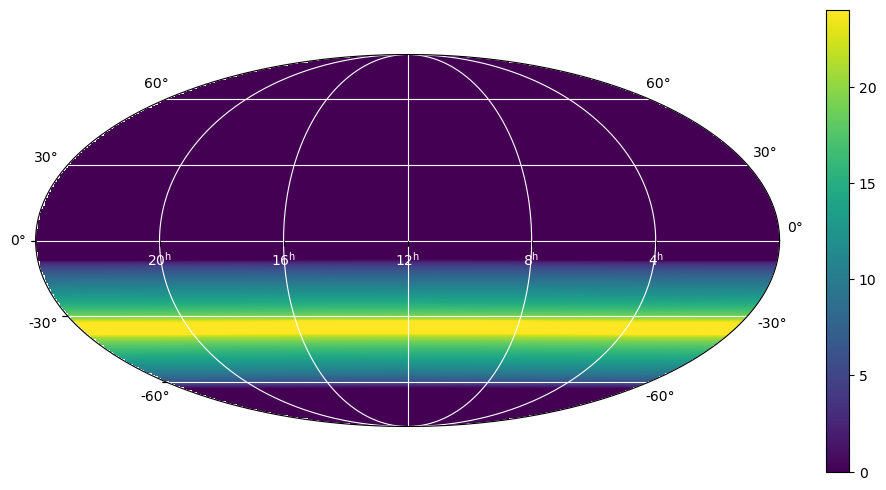

In [17]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1, projection=WCS(mollweide_header), frame_class=EllipticalFrame)
cs = ax.imshow(obstimemap)#, vmin=0, vmax=1.e-8)
ax.coords.grid(color='white')
ax.coords['ra'].set_ticklabel(color='white')
fig.colorbar(cs)